<a href="https://colab.research.google.com/github/thienluc2017/fraud-detection/blob/main/Model_ch%C3%ADnh_XGboost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

- **MSV : 19021324**
- **Public score :**
- **Private score :**

###Gồm 4 chương 
###Chương 1 : phân tích dữ liệu
###Chương 2 : Covert, clean ,xử lý dữ liệu
###Chương 3 : Model  sử dụng, hình ảnh , số liệu
###Chương 4 : Tạo file nạp bài

#**Dữ liệu** 
Dữ liệu là dữ liệu phân loại được chia thành hai tệp `identity` (nhận dạng ) và `transaction` (giao dịch) được nối với nhau  bằng  `TransactionID`.  Không phải tất cả các giao dịch đều có thông tin nhận dạng tương ứng.

- TransactionDT: tính thời gian từ một ngày giờ tham chiếu nhất định (không phải dấu thời gian thực tế)
- TransactionAMT: số tiền thanh toán giao dịch bằng USD
- ProductCD: mã sản phẩm, sản phẩm cho mỗi giao dịch
- card1 - card6: thông tin thẻ thanh toán, chẳng hạn như loại thẻ, loại thẻ, ngân hàng phát hành, quốc gia, v.v.
- addr: địa chỉ
- dist: khoảng cách
- P_ và (R__) email domain : miền email của người mua và người nhận
- C1-C14 : đếm, chẳng hạn như có bao nhiêu địa chỉ được tìm thấy có liên quan đến thẻ thanh toán, v.v. Ý nghĩa thực tế được che giấu.
- D1-D15: hẹn giờ, chẳng hạn như ngày giữa giao dịch trước đó, v.v.
- M1-M9: khớp, chẳng hạn như tên trên thẻ và địa chỉ, v.v.
- Vxxx: Vesta đã thiết kế các tính năng phong phú, bao gồm xếp hạng, đếm và các quan hệ thực thể khác.

### **Thuộc tính phân loại- Giao dịch**

- `ProductCD`
- `card1-card6`
- `addr1, addr2`
- `P_emaildomain`
- `R_emaildomain`
- `M1-M9`

### **Thuộc tính phân loại - Nhận dạng**

- `DeviceType`
- `DeviceInfo`
- `id_12-id_38`

Thêm các thư viện và packages cần thiết

In [ ]:
# các thư viện đọc,xử lý mô hình, tính toán , trực quan dữ liệu ,....
import pandas as pd 
import numpy as np 
from sklearn.model_selection import train_test_split,cross_val_score,cross_val_predict
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
from matplotlib.pyplot import *
import plotly.graph_objs as go
from plotly.offline import iplot, init_notebook_mode
import seaborn as sns
from scipy.stats.mstats import winsorize
import re
import gc
import warnings
warnings.simplefilter("ignore")
plt.style.use('ggplot')
color_pal = [x['color'] for x in plt.rcParams['axes.prop_cycle']]
import os
import sys
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%matplotlib inline
import missingno as msno
from sklearn.model_selection import KFold
import lightgbm as lgb
import xgboost as xgb
from tqdm import tqdm_notebook
from sklearn.metrics import roc_auc_score,roc_curve,auc,confusion_matrix
from sklearn.model_selection import RandomizedSearchCV
import gc
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings('ignore')

Hàm giảm dung lượng bộ nhớ :sử dụng theo https://www.kaggle.com/kyakovlev/ieee-data-minification :

Làm việc với dữ liệu lớn trong khi đào tạo mô hình ML yêu cầu bộ nhớ RAM lớn và dữ liệu trong bài này khá là lớn . Để khắc phục hạn chế này, ta sử dụng một hàm để giảm dung lượng bộ nhớ của dữ liệu. Cách tiếp cận chung là chuyển đổi loại dtype của từng tính năng ('int16', 'int32', 'int64', 'float16', 'float32', 'float64') thành loại dtype thấp nhất có thể.

In [ ]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
#kết nối với drive

Mounted at /content/drive


# **Đọc dữ liệu và hiện thị dữ liệu**
Tập dữ liệu gồm 4 tệp train_transaction, test_transaction, train_identity, test_identity.


In [ ]:
#đọc dữ liệu các tệp
train_transaction = pd.read_csv('/content/drive/MyDrive/data/train_transaction.csv')
test_transaction = pd.read_csv('/content/drive/MyDrive/data/test_transaction.csv')
train_identity = pd.read_csv('/content/drive/MyDrive/data/train_identity.csv')
test_identity = pd.read_csv('/content/drive/MyDrive/data/test_identity.csv')
#giảm bộ nhớ dữ liệu
train_identity = reduce_mem_usage(train_identity)
train_transaction = reduce_mem_usage(train_transaction)
test_identity = reduce_mem_usage(test_identity)
test_transaction = reduce_mem_usage(test_transaction)

Mem. usage decreased to 25.86 Mb (42.7% reduction)
Mem. usage decreased to 542.35 Mb (69.4% reduction)
Mem. usage decreased to 25.44 Mb (42.7% reduction)
Mem. usage decreased to 472.59 Mb (68.9% reduction)


Với mỗi tệp dữ liệu ta sẽ xem xét hình dạng của các tệp dữ liệu:

#**I.Phân tích dữ liệu**

#**1.Tổng quan dữ liệu**

In [ ]:
#kết hợp 2 tập dữ liệu train và test 
train = pd.merge(train_transaction, train_identity, on = 'TransactionID', how = 'left')
test = pd.merge(test_transaction, test_identity, on = 'TransactionID', how = 'left')

In [ ]:
print(train_transaction.shape)
print(test_transaction.shape)
print(train_identity.shape) 
print (test_identity.shape)

(590540, 394)
(506691, 393)
(144233, 41)
(141907, 41)


In [ ]:
print(train.info(), "\n")
print(test.info(), "\n")

<class 'pandas.core.frame.DataFrame'>
Int64Index: 590540 entries, 0 to 590539
Columns: 434 entries, TransactionID to DeviceInfo
dtypes: float16(354), float32(45), int16(1), int32(2), int8(1), object(31)
memory usage: 650.5+ MB
None 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 506691 entries, 0 to 506690
Columns: 433 entries, TransactionID to DeviceInfo
dtypes: float16(346), float32(53), int16(1), int32(2), object(31)
memory usage: 565.4+ MB
None 



In [ ]:
train_transaction.sample(5) 
#hiển thị 5 hàng dữ liệu bất kỳ trong tệp train_transaction


,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,...,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
333597,3320597,0,8207427,317.5000,W,15651,417.0,150.0,visa,226.0,debit,330.0,87.0,NaN,NaN,aol.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
469705,3456705,0,12104517,59.0000,W,7669,455.0,150.0,mastercard,126.0,debit,204.0,87.0,NaN,NaN,yahoo.com,NaN,1.0,2.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,0.0,0.0,0.0,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,1.0,59.0,59.0,59.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,59.0,59.0,59.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
555673,3542673,0,14681852,57.9375,W,4295,543.0,150.0,mastercard,224.0,debit,264.0,87.0,23.0,NaN,yahoo.com,NaN,2.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,3.0,2.0,0.0,NaN,NaN,32.0,24.0,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
87168,3074168,0,1828827,100.0000,R,12598,111.0,150.0,visa,166.0,debit,299.0,87.0,NaN,NaN,yahoo.com,yahoo.com,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,NaN,NaN,0.0,NaN,30.171875,0.166626,...,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
266806,3253806,0,6463027,34.0000,W,4967,290.0,150.0,visa,226.0,debit,203.0,87.0,76.0,NaN,yahoo.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
test_transaction.sample(5) 
#hiển thị 5 hàng dữ liệu bất kỳ trong tệp test_transaction


,TransactionID,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,...,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
172538,3836087,24355323,59.0000,W,12418,514.0,150.0,mastercard,224.0,debit,126.0,87.0,NaN,NaN,gmail.com,NaN,2.0,3.0,0.0,0.0,0.0,2.0,0.0,0.0,1.0,0.0,1.0,1.0,8.0,2.0,0.0,NaN,NaN,318.0,206.0,NaN,NaN,NaN,NaN,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
504421,4167970,34133372,135.0000,W,6019,583.0,150.0,visa,226.0,credit,251.0,87.0,8.0,NaN,anonymous.com,NaN,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,561.0,373.0,NaN,NaN,NaN,NaN,620.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
221517,3885066,26166725,1335.0000,W,10112,360.0,150.0,visa,166.0,debit,299.0,87.0,NaN,NaN,gmail.com,NaN,1.0,2.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,0.0,0.0,0.0,NaN,NaN,NaN,NaN,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1335.150024,1335.150024,1335.150024,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1335.150024,1335.150024,1335.150024,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
222606,3886155,26188375,58.9375,W,13108,215.0,150.0,visa,226.0,debit,191.0,87.0,1.0,NaN,gmail.com,NaN,2.0,2.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,8.0,2.0,133.0,133.0,49.0,132.0,25.0,NaN,NaN,NaN,NaN,132.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
278314,3941863,28046554,200.0000,S,7585,553.0,150.0,visa,226.0,credit,272.0,87.0,NaN,NaN,NaN,gmail.com,3.0,4.0,0.0,2.0,0.0,0.0,0.0,2.0,0.0,2.0,3.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,38.0,38.0,7.582031,0.583496,0.0,...,0.0,0.0,1.0,1.0,1.0,1.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
train_identity.sample(5) 
#hiển thị 5 hàng dữ liệu bất kỳ trong tệp train_identity


,TransactionID,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
71028,3192965,-5.0,124839.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,100.0,NotFound,52.0,NaN,Found,Found,225.0,NaN,254.0,507.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Found,Found,NaN,chrome 63.0,NaN,NaN,NaN,F,F,T,F,desktop,NaN
1508,2994375,0.0,179064.0,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,100.0,NotFound,NaN,-300.0,New,NotFound,166.0,NaN,529.0,484.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,Mac OS X 10_13_1,safari generic,24.0,1920x1080,match_status:2,T,F,T,T,desktop,MacOS
75978,3220248,-5.0,128145.0,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,100.0,NotFound,52.0,NaN,New,NotFound,225.0,NaN,266.0,315.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,NaN,chrome 64.0,NaN,NaN,NaN,F,F,T,F,desktop,Windows
81985,3252539,-50.0,281306.0,NaN,NaN,-6.0,-6.0,NaN,NaN,NaN,NaN,100.0,NotFound,49.0,NaN,New,NotFound,225.0,NaN,384.0,507.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,NaN,chrome 64.0 for android,NaN,NaN,NaN,F,F,T,F,mobile,hi6210sft Build/MRA58K
55243,3111580,-5.0,82617.0,2.0,0.0,13.0,-3.0,NaN,NaN,3.0,0.0,100.0,NotFound,52.0,-300.0,Found,Found,166.0,13.0,410.0,600.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Found,Found,Windows 7,chrome 63.0,24.0,1280x1024,match_status:2,T,F,T,T,desktop,Windows


In [ ]:
test_identity.sample(5) 
#hiển thị 5 hàng dữ liệu bất kỳ trong tệp test_identity

,TransactionID,id-01,id-02,id-03,id-04,id-05,id-06,id-07,id-08,id-09,id-10,id-11,id-12,id-13,id-14,id-15,id-16,id-17,id-18,id-19,id-20,id-21,id-22,id-23,id-24,id-25,id-26,id-27,id-28,id-29,id-30,id-31,id-32,id-33,id-34,id-35,id-36,id-37,id-38,DeviceType,DeviceInfo
89975,4064053,0.0,42333.0,3.0,0.0,6.0,0.0,NaN,NaN,3.0,0.0,100.0,NotFound,NaN,-300.0,Found,Found,166.0,17.0,286.0,600.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Found,Found,iOS 11.3.1,google search application 63.0,32.0,1334x750,match_status:2,T,F,T,T,mobile,iOS Device
13509,3736447,-10.0,374055.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,100.0,NotFound,52.0,NaN,Found,Found,225.0,NaN,153.0,325.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Found,Found,NaN,chrome 65.0,NaN,NaN,NaN,F,F,T,F,desktop,Windows
36446,3863852,-5.0,68634.0,0.0,0.0,0.0,-1.0,NaN,NaN,0.0,0.0,100.0,NotFound,52.0,-300.0,Found,Found,166.0,NaN,410.0,277.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Found,Found,Windows 10,chrome 69.0,24.0,1920x1080,match_status:2,T,F,T,F,desktop,Windows
32742,3845732,0.0,36453.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,100.0,NotFound,NaN,-300.0,Found,Found,166.0,NaN,341.0,501.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Found,Found,iOS 11.4.1,mobile safari 11.0,32.0,1334x750,match_status:2,T,F,T,T,mobile,iOS Device
132236,4150131,0.0,83486.0,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,100.0,NotFound,NaN,-300.0,New,NotFound,166.0,NaN,390.0,489.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,iOS 12.1.0,mobile safari 12.0,32.0,2048x1536,match_status:2,T,F,T,T,mobile,iOS Device


- Hình dạng của các tệp là khá lớn khi dung lượng của tập train rất lớn lên tới 650MB và tập test cũng rất lớn lên tới 565MB .
- Có sự khác nhau giữa hình dạng các tệp train và test cũng như các cột dữ liệu có giá trị NaN rất nhiều .
- Qua hai ý trên, cho thấy đang có dữ liệu bị mất mát (missing data ) cũng như các cột bị lệch nhau .

#**2.Dữ liệu bị gán nhãn lỗi trong tập test_identity**

In [ ]:
#in ra các cột bị đánh nhãn lỗi
def differentcolumns(traincols, testcols):
    for i in traincols:
        if i not in testcols:
            print(i)
            
differentcolumns(train_identity.columns, test_identity.columns) 

id_01
id_02
id_03
id_04
id_05
id_06
id_07
id_08
id_09
id_10
id_11
id_12
id_13
id_14
id_15
id_16
id_17
id_18
id_19
id_20
id_21
id_22
id_23
id_24
id_25
id_26
id_27
id_28
id_29
id_30
id_31
id_32
id_33
id_34
id_35
id_36
id_37
id_38


- Những cột bị lệch,đánh label lỗi giữa tập train_identity ,test_identity .

#**3.Dữ liệu bị mất mát (missing data)**

In [ ]:
def missing_data(df,n=10,temp=80):
    
   # trả về các cột bị mất mát dữ liệu và tỉ lệ mất mát dữ liệu trên ngưỡng nào đó .
    
    dff = (df.isnull().sum()/df.shape[0])*100
    dff = dff.reset_index()
    dff.columns = ['column','percent']
    dff = dff.sort_values(by=['percent'],ascending=False).reset_index(drop=True)
    print(f'{df.isnull().any().sum()} columns : missing values.')
    print(f'{dff[dff["percent"] > temp].shape[0]} columns : missing percents than {temp}%')
    if n:
        return dff.head(n)
    else:
        return dff

In [ ]:
missing_data(train_transaction,temp=90)

374 columns : missing values.
2 columns : missing percents than 90%


,column,percent
0,dist2,93.628374
1,D7,93.409930
2,D13,89.509263
3,D14,89.469469
4,D12,89.041047
5,D6,87.606767
6,D9,87.312290
7,D8,87.312290
8,V153,86.123717
9,V139,86.123717


In [ ]:
missing_data(test_transaction,temp=90)

345 columns : missing values.
1 columns : missing percents than 90%


,column,percent
0,dist2,92.809030
1,D7,88.132215
2,D12,86.332104
3,D8,85.328731
4,D9,85.328731
5,V138,85.043153
6,V158,85.043153
7,V157,85.043153
8,V156,85.043153
9,V155,85.043153


In [ ]:
missing_data(train_identity,temp=90)

38 columns : missing values.
9 columns : missing percents than 90%


,column,percent
0,id_24,96.708798
1,id_25,96.441868
2,id_07,96.425922
3,id_08,96.425922
4,id_21,96.423149
5,id_26,96.420375
6,id_23,96.416215
7,id_27,96.416215
8,id_22,96.416215
9,id_18,68.722137


In [ ]:
missing_data(test_identity,temp=90)

38 columns : missing values.
9 columns : missing percents than 90%


,column,percent
0,id-24,96.659784
1,id-25,96.449083
2,id-26,96.443445
3,id-21,96.434989
4,id-07,96.434989
5,id-08,96.434989
6,id-23,96.432875
7,id-22,96.432875
8,id-27,96.432875
9,id-18,64.149055


In [ ]:
# lấy các cột có tỉ lệ missing data trên 50%
df_missing = missing_data(train,n=None,temp=75)
missing_cols = df_missing['column']
nan_dict = {}
for i in missing_cols:
    count = train[i].isnull().sum()
    try:
        nan_dict[count].append(i)
    except:
        nan_dict[count] = [i]
        
for k,v in nan_dict.items():
    print(f'--------------------------------------------' )
    print(f'NAN count = {k} percent: {(int(k)/train.shape[0])*100} %')
    print(v)

414 columns : missing values.
208 columns : missing percents than 75%
--------------------------------------------
NAN count = 585793 percent: 99.19615944728554 %
['id_24']
--------------------------------------------
NAN count = 585408 percent: 99.13096487960172 %
['id_25']
--------------------------------------------
NAN count = 585385 percent: 99.12707013919464 %
['id_07', 'id_08']
--------------------------------------------
NAN count = 585381 percent: 99.12639279303687 %
['id_21']
--------------------------------------------
NAN count = 585377 percent: 99.12571544687913 %
['id_26']
--------------------------------------------
NAN count = 585371 percent: 99.1246994276425 %
['id_27', 'id_23', 'id_22']
--------------------------------------------
NAN count = 552913 percent: 93.62837403054831 %
['dist2']
--------------------------------------------
NAN count = 551623 percent: 93.40992989467267 %
['D7']
--------------------------------------------
NAN count = 545427 percent: 92.3607206

Text(0.5, 1.0, 'Percentage of Missing Values')

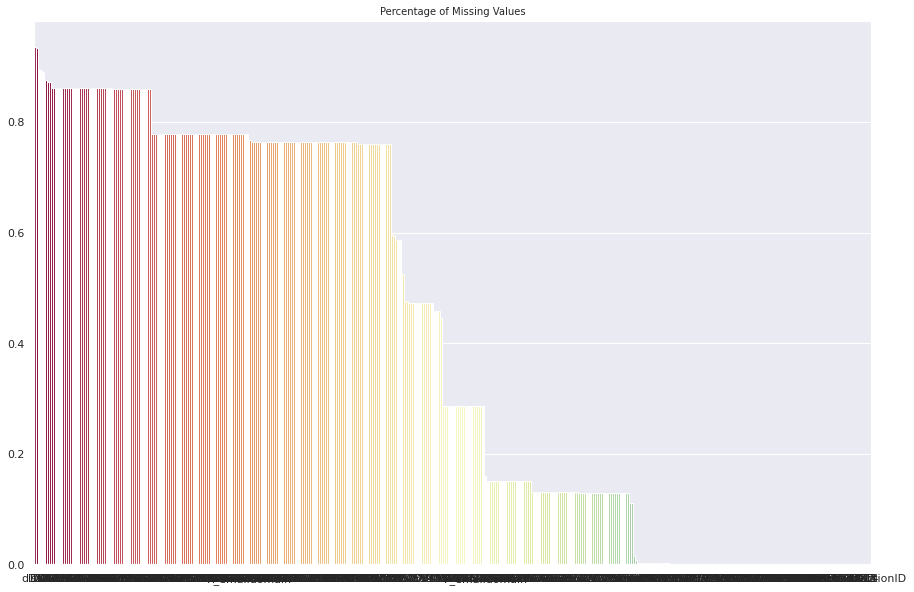

In [ ]:
# vẽ biểu đồ histogram cho các cột bị missing data
figure(figsize=(15, 10))

sns.barplot(y=train_transaction.isnull().sum().sort_values(ascending=False)/len(train_transaction),
            x=train_transaction.isnull().sum().sort_values(ascending=False).index,
            palette = "Spectral")
title("Percentage of Missing Values", size=10)

- Các cột như id_21,id_22,id_23,id_24,id_25,id_26,id_27, id_07,id_08 có tỉ lệ mất mát dữ liệu rất lớn(trên 96%) .
- Việc xử lý dữ liệu bị thiếu là rất quan trọng trong quá trình tiền xử lý tập dữ liệu vì nhiều thuật toán học máy không hỗ trợ các giá trị bị thiếu.

#**4. IsFraud**

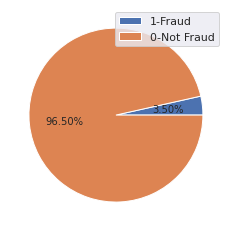

In [ ]:
# Vẽ biểu đồ pie graph cho thuộc tính IsFraud

labels = '1-Fraud', '0-Not Fraud'
sizes = [len(train_transaction[train_transaction['isFraud'] == 1]), len(train_transaction[train_transaction['isFraud'] == 0])]
explode = (0.3, 0)  # explode 1st slice
#train_transaction.groupby('isFraud')['isFraud'].count().plot(kind="bar")
# Plot
plt.pie(sizes, autopct='%1.2f%%', shadow=False)
plt.legend(labels)
plt.axis()
plt.show()

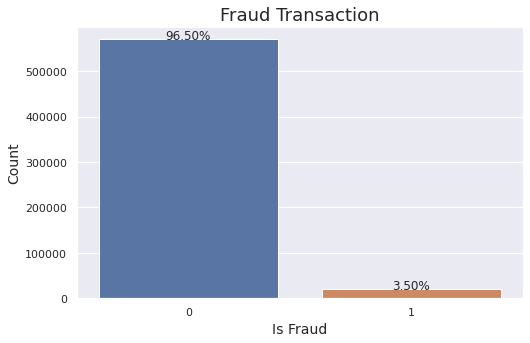

In [ ]:
#biểu đồ barchart cho thuộc tính IsFraud
fig, ax  = plt.subplots(figsize=(8, 5))
sns.countplot(x='isFraud', data=train_transaction, ax=ax)
ax.set_title('Fraud Transaction', fontsize=18)
ax.set_xlabel('Is Fraud', fontsize=14)
ax.set_ylabel('Count', fontsize=14)
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height,
            f'{height/train_transaction.shape[0] * 100:.2f}%',
            ha='center', fontsize=12)

- Trong bộ dữ liệu , có 96,5% giao dịch không phải là gian lận và 3,5% còn lại là gian lận và qua dashboard 1 cho thấy tập dataset đang bị unbalance rất nhiều .Đây cũng chính là lý do tôi sử dụng ROC(AUC) để làm thước đo cho tác vụ phát hiện giao dịch gian lận trực tuyến cho dataset này chứ không phải accurancy, f1 .

#**5.Transaction Date**

Transaction date là một thuộc tính có thời gian từ mốc một thời điểm cụ thể gốc nào đó và theo bài đăng khoảng thời gian của tập dữ liệu là khoảng 1 năm . Ví dụ: 85700 có thể là 85700 giây từ một thời điểm cụ thể, ví dụ là từ ngày 05/01/2022 13:15:43 chiều. Ở đây tôi muốn kiểm tra xem liệu thu được trong train và test có liên tục theo thời gian không.  Điều này rất quan trọng đối với việc khi phân chia 2 tập train-test 

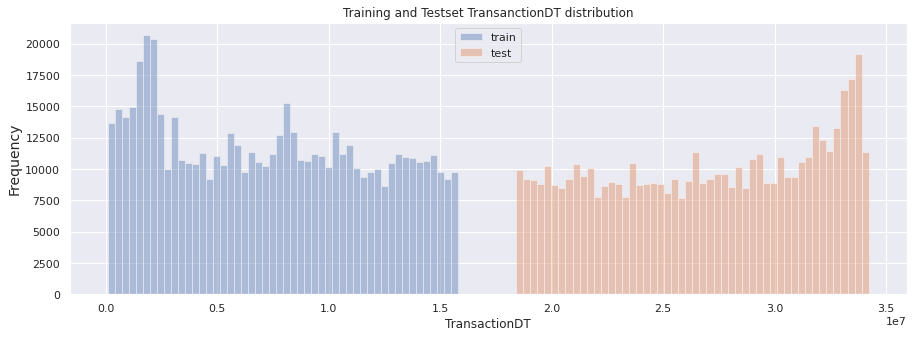

In [ ]:
#Biểu đồ histogram cho thuộc tính TransactionDT
fig, ax = plt.subplots(figsize=(15,5))
sns.distplot(train_transaction['TransactionDT'], kde=False, ax=ax, label='train')
sns.distplot(test_transaction['TransactionDT'], kde=False, ax=ax, label='test')
ax.set_title('Training and Testset TransanctionDT distribution')
ax.set_ylabel('Frequency', fontsize=14)
ax.legend()

Text(0.5, 1.0, 'Test')

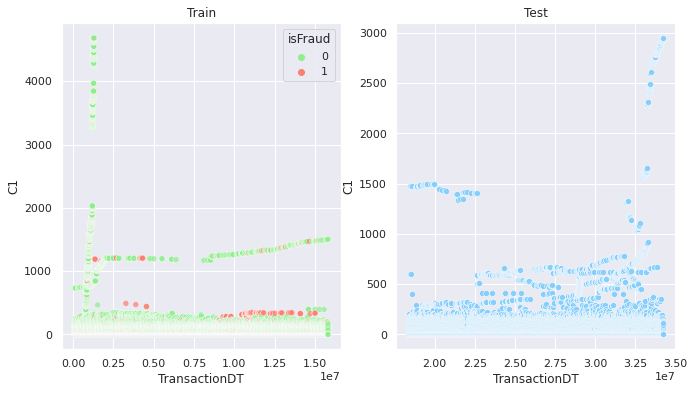

In [ ]:
#biểu đồ scatterplot cho thuộc tính TransactionDT
plt.figure(figsize=(11,6))
plt.subplot(1,2,1)
sns.scatterplot(x="TransactionDT",y="C1",hue="isFraud",palette=['#90EE90', '#FA8072'], data=train,alpha=0.7,hue_order=[0,1])
plt.title('Train')
plt.subplot(1,2,2)
sns.scatterplot(x="TransactionDT",y="C1", color='#87CEFA', data=test[~test['C1'].isnull()])
plt.title('Test')

- Phân bố của histogram là phân bố dạng răng lược (comb) cho thấy có những khoảng thời gian thì số người giao dịch tăng đột biến cũng như số lượng giao dịch dựa vào yếu tố chủ quan của người tiêu dùng là chủ yếu .
- Thời gian giao dịch của tập train và test không trùng lặp, điều này cho thấy tập train và test được phân chia theo thời gian. Ngoài ra, có khoảng cách một tháng giữa đào tạo và tập kiểm tra.Điều đó có nghĩa là dữ liệu đào tạo phải từ một khoảng thời gian trước đó và dữ liệu kiểm tra phải từ một khoảng thời gian sau đó.
- Từ biểu đồ scatterplot ta có thể thấy được các điểm ngoại lệ (outlier) và xem xét được những điểm cần chú ý.

#**6.TransactionAmt**

TransactionAmt là thuộc tính rời rạc biểu thị số tiền được tính bằng USD .

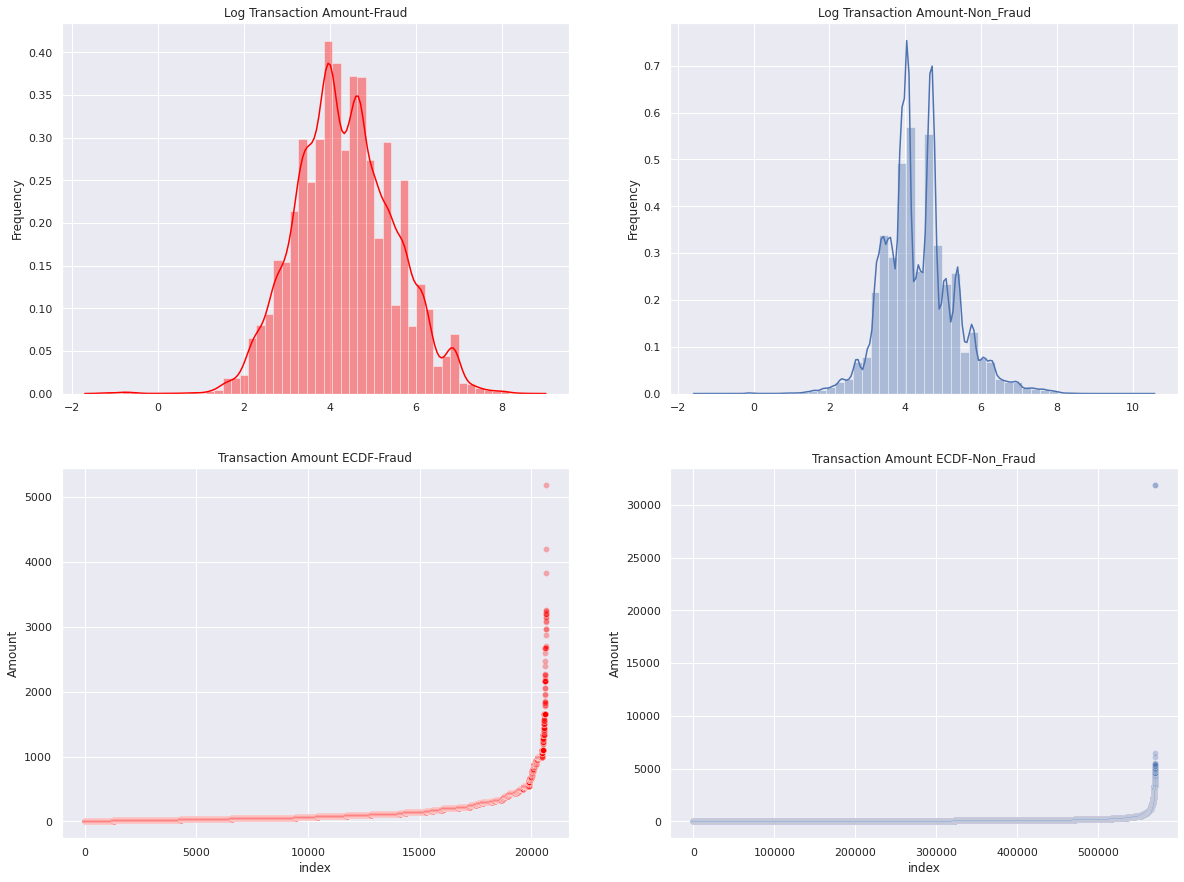

In [ ]:
#biểu đồ histogram cho thuộc tính TransactionAmt
ig, ax = plt.subplots(2, 2, figsize=(20, 15))

fraud_amt = train_transaction[train_transaction['isFraud'] == 1]['TransactionAmt'].values
non_fraud_amt = train_transaction[train_transaction['isFraud'] == 0]['TransactionAmt'].values

sns.distplot(np.log(fraud_amt), ax=ax[0][0], color='red')
ax[0][0].set_title("Log Transaction Amount-Fraud")
ax[0][0].set_ylabel("Frequency")

sns.distplot(np.log(non_fraud_amt), ax=ax[0][1])
ax[0][1].set_title("Log Transaction Amount-Non_Fraud")
ax[0][1].set_ylabel("Frequency")

sns.scatterplot(range(train_transaction[train_transaction['isFraud'] == 1].shape[0]),
            np.sort(fraud_amt),
            alpha=0.3,
            color='red',
            ax=ax[1][0])
ax[1][0].set_title("Transaction Amount ECDF-Fraud")
ax[1][0].set_xlabel("index")
ax[1][0].set_ylabel("Amount")

sns.scatterplot(range(train_transaction[train_transaction['isFraud'] == 0].shape[0]),
            np.sort(non_fraud_amt),
            alpha=0.3,
            ax=ax[1][1])
ax[1][1].set_title("Transaction Amount ECDF-Non_Fraud")
ax[1][1].set_xlabel("index")
ax[1][1].set_ylabel("Amount");

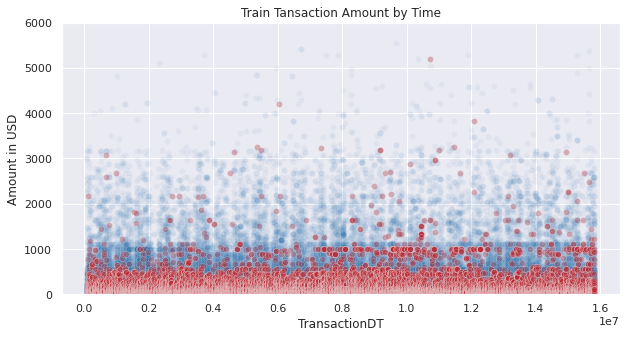

In [ ]:
#biểu đồ scatterplot cho biểu đồ TransactionAmt
cmap=sns.color_palette("RdBu", n_colors=7)
fig, ax = plt.subplots(figsize=(10,5))
sns.scatterplot(x=train_transaction['TransactionDT'],
                y=train_transaction['TransactionAmt'],
                alpha=0.05,
                color=cmap[6])
ax.set_title("Train Tansaction Amount by Time")
ax.set_xlabel("TransactionDT")
ax.set_ylabel("Amount in USD")
ax.set_ylim(0, 6000)

fraud_entries = train_transaction.loc[train_transaction['isFraud'] == 1]
sns.scatterplot(x=fraud_entries['TransactionDT'],
                y=fraud_entries['TransactionAmt'],
                alpha=0.3,
                color=cmap[0]);

- Từ biểu đồ histogram ,ta có thể thấy histogram ở dạng skew-rleft . Vì vậy, chúng tôi sẽ thực hiện log-transform để xem rõ hơn sự phân bố. Sau khi áp dụng log-transform, số tiền gian lận và không gian lận sẽ trở thành phân phối bình thường.
- Từ biểu đồ scatterplot ,ta có thể thấy rằng có một điểm trong tập train là một outlier(ngoại lệ ) rõ ràng . Vậy nên tôi sẽ xóa điểm ngoại lệ này vì nó có thể ảnh hưởng đến các mô hình của chúng ta khi dự đoán. Thứ hai, những ngoại lệ như thế này có thể gây ra vấn đề overfitting . Ví dụ, các mô hình dựa trên cây có thể đưa các ngoại lệ này vào các nút lá điều đó sẽ làm nhiều và không phải là một phần của mô hình chung. Do đó, tôi quyết định loại bỏ các giá trị lớn hơn 30.000 trong tập huấn luyện.
- Từ biểu đồ dotplot và histogram t thấy các giao dịch với 'LogTransactionAmt' lớn hơn 5,5 (244 đô la) và nhỏ hơn 3,3 (27 đô la) có tần suất và mật độ xác suất bị lừa đảo cao hơn. Mặt khác, những cái có 'LogTransactionAmt' từ 3,3 đến 5,5 có khả năng là giao dịch không gian lậ cao hơn.

#**7.Product CD**

ProductCD là mã sản phẩm được liên kết với mỗi giao dịch.

W là giá trị thường xuyên nhất, tiếp theo là C và R.
Tỷ lệ gian lận trong sản phẩm C là cao nhất, tiếp theo là S và H.

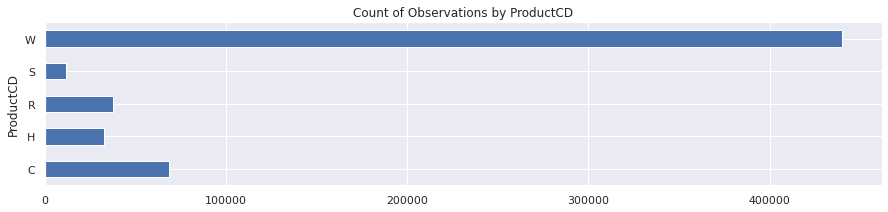

In [ ]:
# Bart chart cho số lượng các mã trong Product CD
train_transaction.groupby('ProductCD') \
    ['TransactionID'].count() \
    .sort_index() \
    .plot(kind='barh',
          figsize=(15, 3),
         title='Count of Observations by ProductCD')
plt.show()

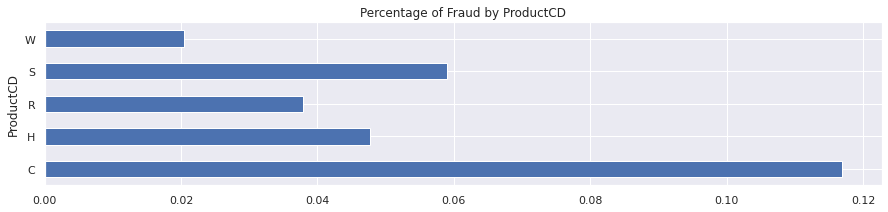

In [ ]:
# Bart chart cho số lượng các mã bị gian lận trong Product CD
train_transaction.groupby('ProductCD')['isFraud'] \
    .mean() \
    .sort_index() \
    .plot(kind='barh',
          figsize=(15, 3),
         title='Percentage of Fraud by ProductCD')
plt.show()

- Đây là mã sản phẩm được liên kết với mỗi giao dịch. Hãy cho chúng tôi biết có bao nhiêu phần trăm giao dịch là gian lận giữa các mã sản phẩm khác nhau

- Chúng ta có thể thấy rằng trong số các giao dịch liên quan đến mã sản phẩm C, khoảng 12 phần trăm là giao dịch gian lận. tương tự gần 6% giao dịch là gian lận giữa các mã sản phẩm.

#**8.Card features**

Có 6 tính năng phân loại thẻ khác nhau từ card 1 đến card 6. Tuy nhiên, card1, card2, card3 và card5 được mã hóa dưới dạng giá trị số.Ở đây tôi không được cho biết các tính năng chính xác ý nghĩa cho các tính năng thẻ. Đây có thể là thông tin thanh toán của các loại thẻ khác nhau như atm, QR,...

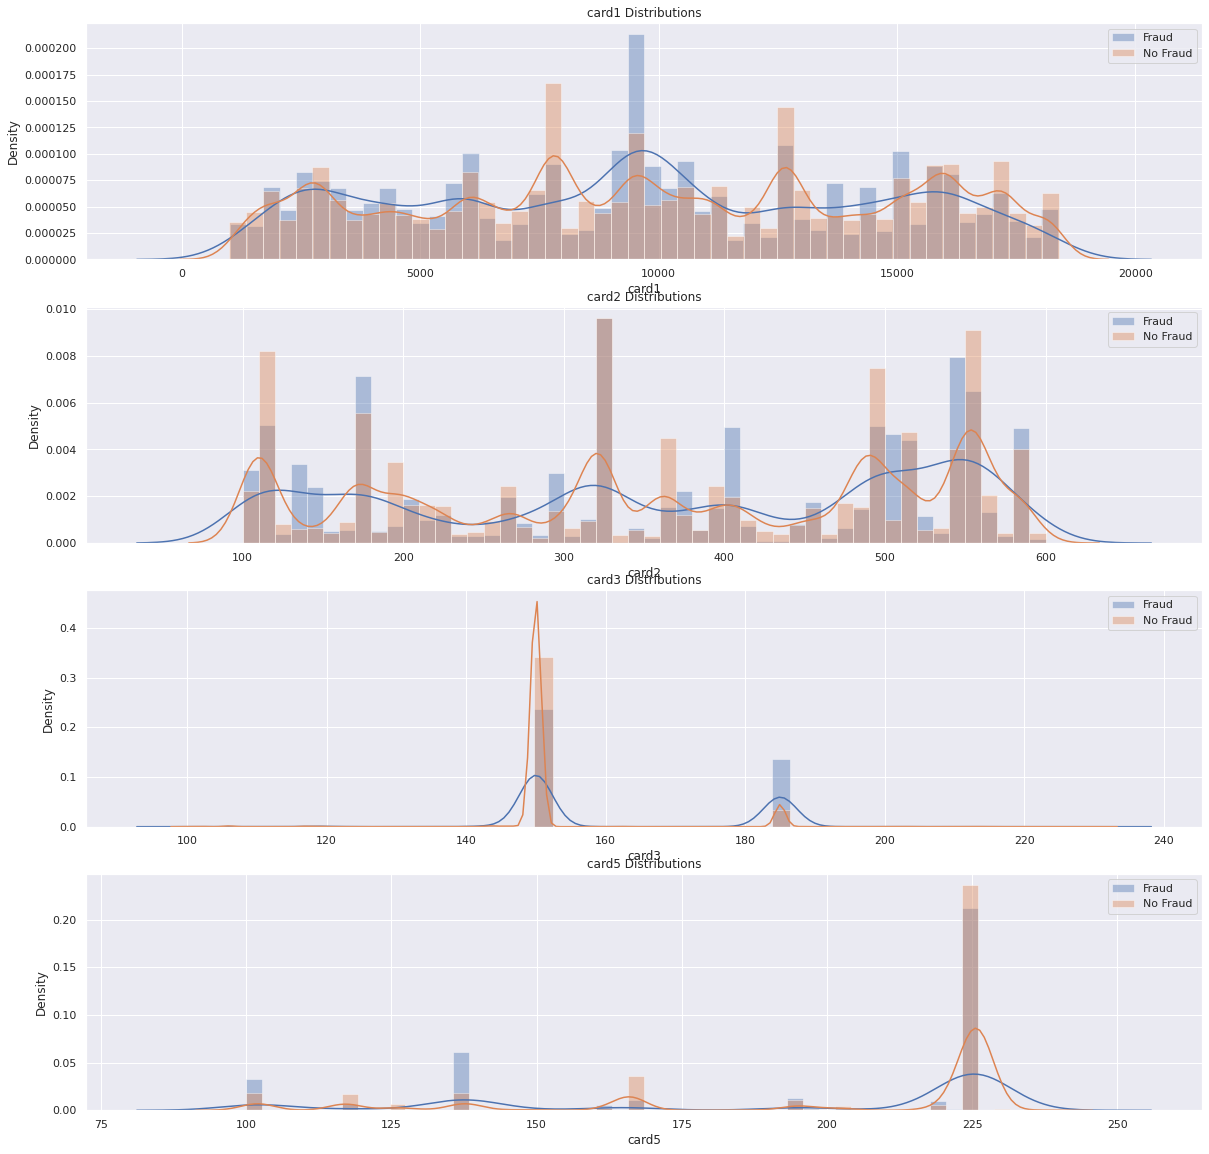

In [ ]:
#Biểu đồ histogram cho từng card
fig, ax = plt.subplots(4, figsize=(20, 20))
cards_col = train_transaction[['card1', 'card2', 'card3', 'card5']].columns
for i, card in enumerate(cards_col):
    sns.distplot(train_transaction[train_transaction['isFraud'] == 1][card],
                 bins=50,
                 ax=ax[i],
                 label='Fraud')
    sns.distplot(train_transaction[train_transaction['isFraud'] == 0][card],
                 bins=50,
                 ax=ax[i],
                 label='No Fraud')
    
    ax[i].legend()
    ax[i].set_title(str(card) + " Distributions")

- Nhiều giá trị của card3 và card5 có tần số thấp .
- Trong card3 thì hai giá trị 150 và 185 là các giá trị thường xuyên nhất trong cột và có tới có 2,4% gian lận khi có giá trị 150 và 13% gian lận khi có giá trị 185. Cho thấy khi có 2 giá trị 150 và 185 trong thuộc tính card 3 thì tỉ lệ lừa đảo là khá cao.
- Trong card5, các giá trị thường gặp nhất là 226, 224, 166 và nó đại diện lên tới 73% dữ liệu .

#**9.addr1 và addr2**

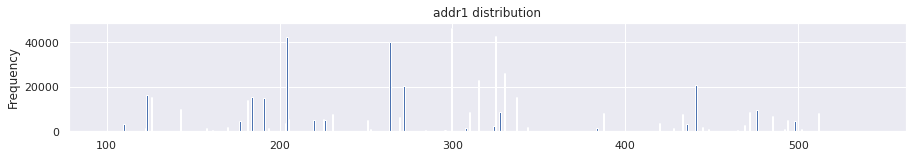

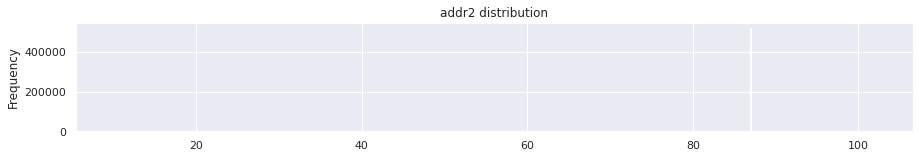

In [ ]:
#Biểu đồ histogram cho thuộc tính addr1 và addr2
train_transaction['addr1'].plot(kind='hist', bins=500, figsize=(15, 2), title='addr1 distribution')
plt.show()
train_transaction['addr2'].plot(kind='hist', bins=500, figsize=(15, 2), title='addr2 distribution')
plt.show()

- Ta thấy các giá trị 299, 325, 204, 264,)xảy ra thường xuyên hơn bất kỳ giá trị nào khác .
- Ta thấy phần trăm gian lận dường như cho thấy rằng các nhóm tần suất thấp hơn có phần trăm gian lận cao hơn các giá trị tần suất cao hơn .
- Ta thấy có khá nhiều điểm đáng lưu ý .Thứ nhất ,giá trị 87 chiếm khoảng 88% tổng số giao dịch. Ngoài ra, giá trị 87 chiếm 96% tổng số tiền giao dịch bằng USD.Thứ hai,giống như với Addr1, có vẻ như các nhóm tần suất thấp hơn có tỷ lệ gian lận cao hơn. Đặc biệt là giá trị 65,0, nó chỉ có khoảng 0,01% mục nhập nhưng với tỷ lệ gian lận là 53%.

#**10. C1-C14**

C1-C14: đếm, chẳng hạn như có bao nhiêu địa chỉ được tìm thấy có liên quan đến thẻ thanh toán, v.v. Ý nghĩa thực tế được che giấu.

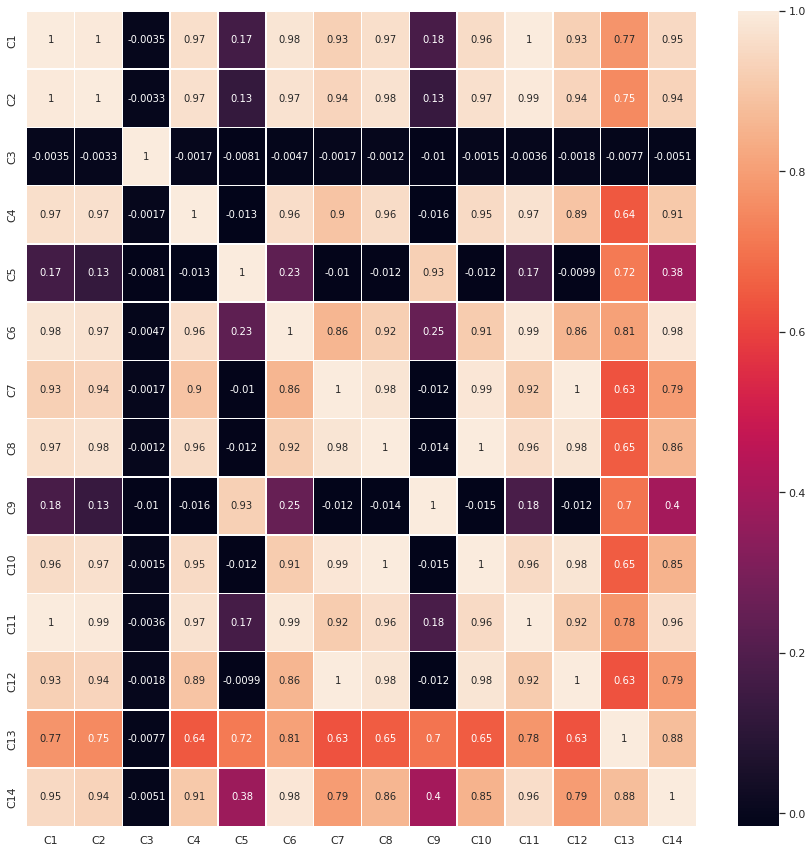

In [ ]:
#biểu đồ correlation matrix cho thuộc tính C1-C14
corr = train_transaction.iloc[:, 17:31].corr()
fig, ax = plt.subplots(figsize=(15, 15))
sns.heatmap(corr, linewidths=.5, annot=True, ax=ax)

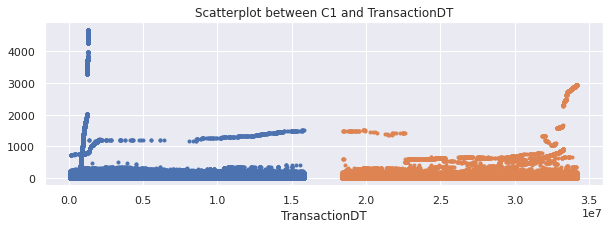

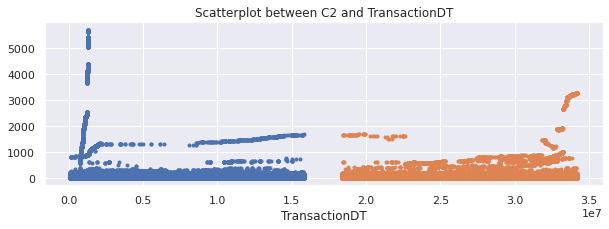

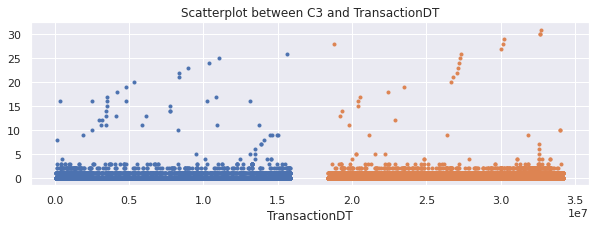

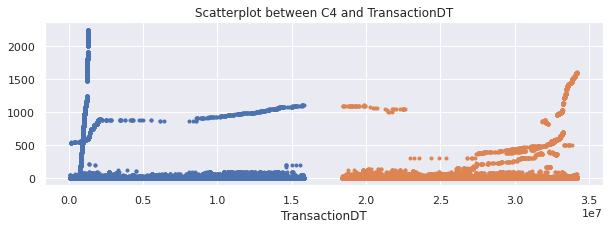

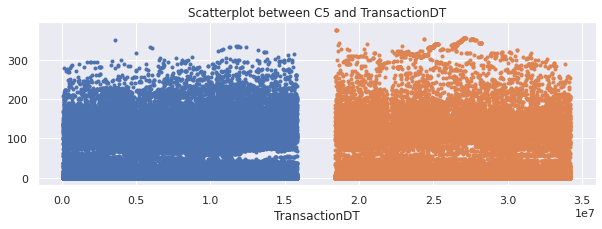

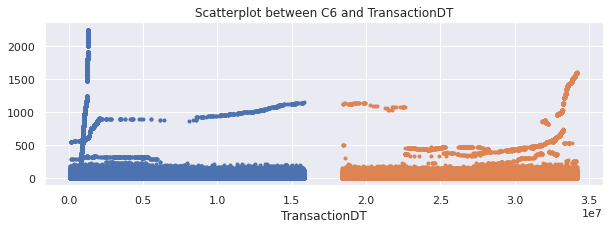

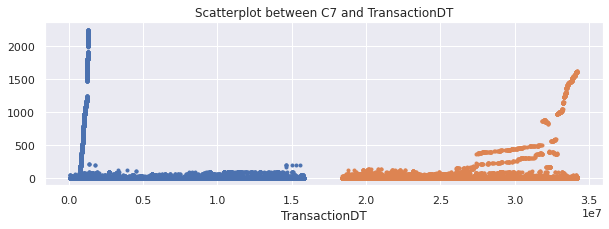

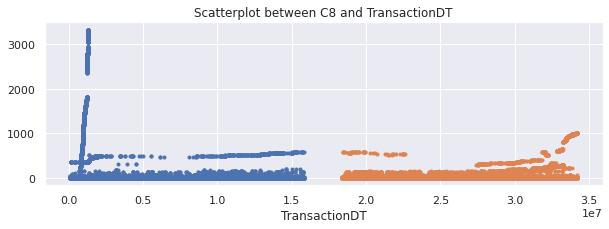

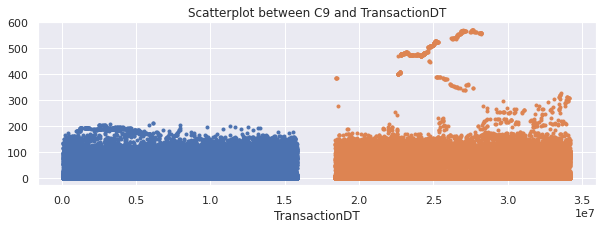

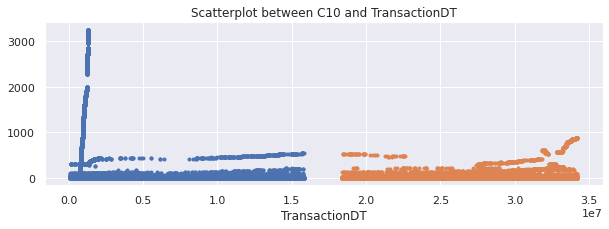

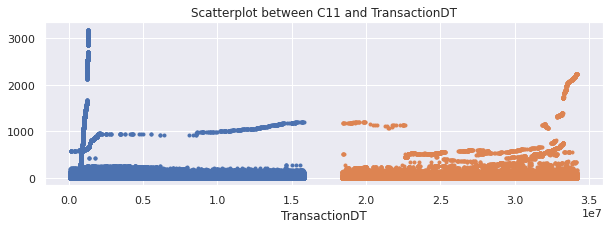

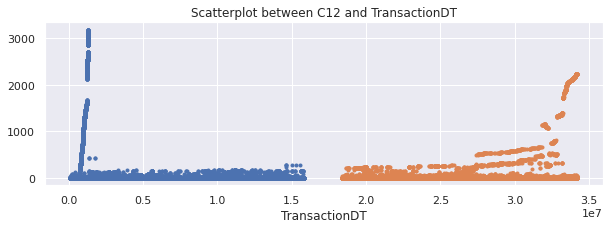

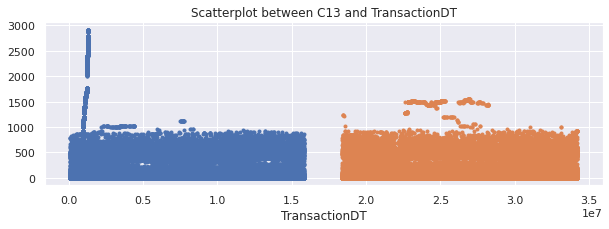

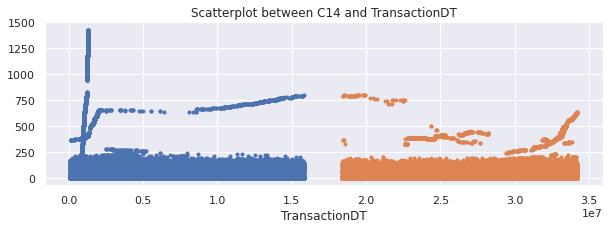

In [ ]:
#biểu đồ correlation matrix cho thuộc tính C1-C14 so sánh với thuộc tính TransactionDT
c_features = list(train_transaction.columns[17:31])
for i in c_features:
    train_transaction.set_index('TransactionDT')[i] \
    .plot(style='.', title=f'Scatterplot between {i} and TransactionDT',
          figsize=(10, 3))
    test_transaction.set_index('TransactionDT')[i] \
    .plot(style='.', figsize=(10, 3))
    plt.show()

- Từ biểu đồ correlation heatmap ta có thể thấy được rõ ràng và chi tiết sự tương quan giữa các thuộc tính với nhau. Đây là thông tin chủ yếu để giúp tôi giảm chiều dữ liệu trong phần sau .
- Từ biểu đồ scatterplot của C1-C14 , ta có thể thấy được liệu có sự tương tự giữa hình dạng cũng như phân bố của C1-C14 với “TransactionDT”.Đây là thông tin quan trọng để đáng giá xem tại sao lại có sự khác nhau đó và điều đó thể hiện điều gì.

#**11. D1-D15**

D1-D15: dữ liệu timedelta , chẳng hạn như ngày giữa giao dịch trước đó, v.v.

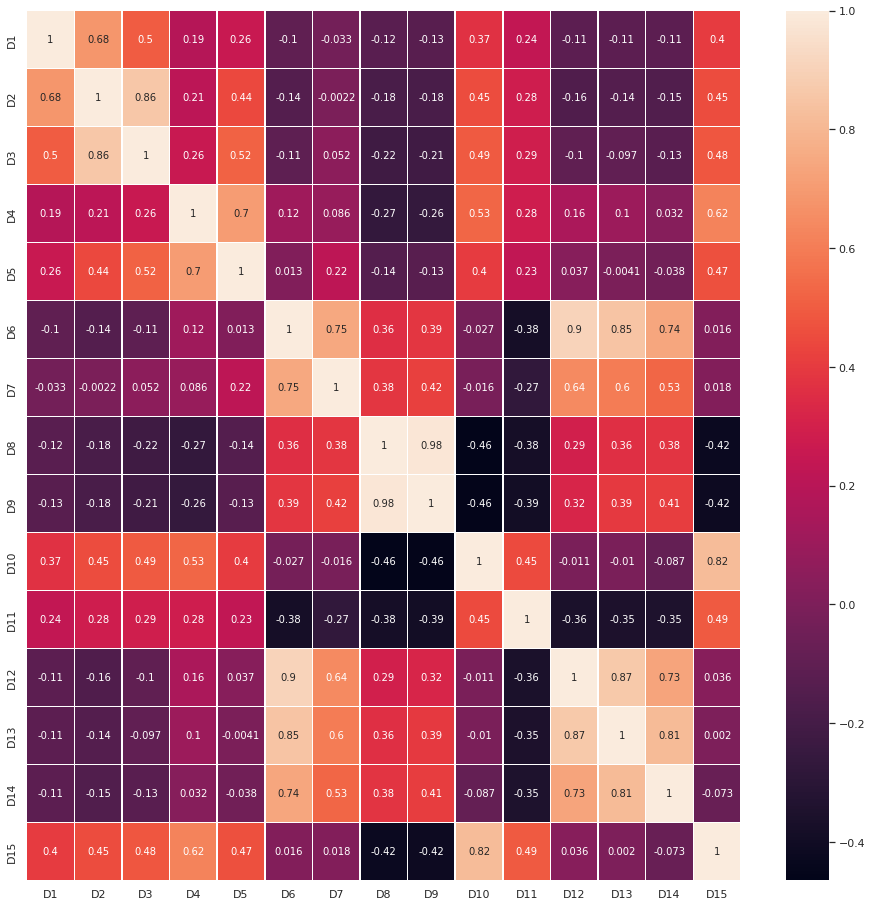

In [ ]:
d_features = list(train_transaction.columns[31:46])
corr = train_transaction[d_features].fillna(-999).corr()
fig, ax = plt.subplots(figsize=(16, 16))
sns.heatmap(corr, linewidths=.5, annot=True, ax=ax);

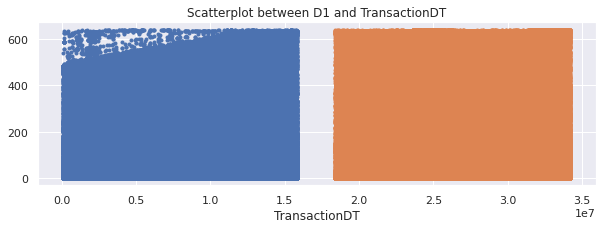

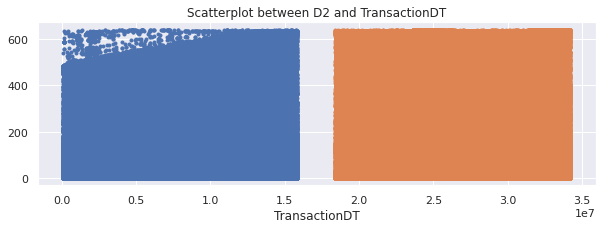

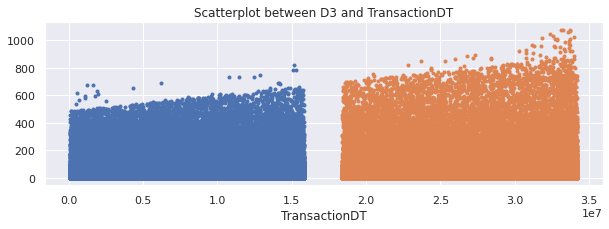

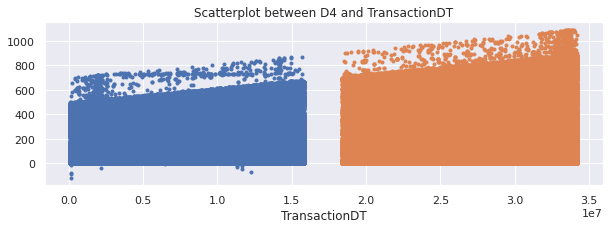

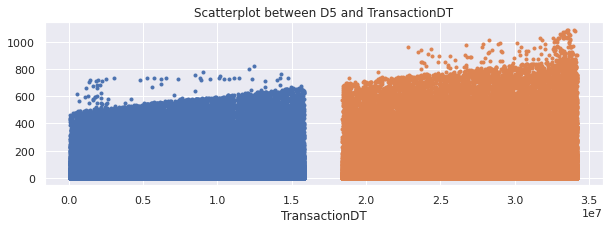

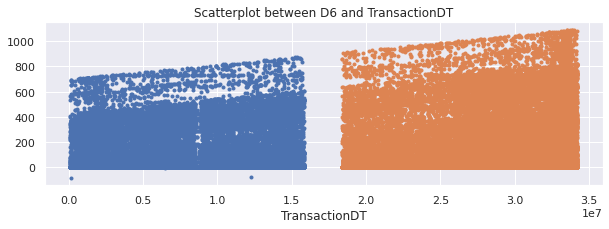

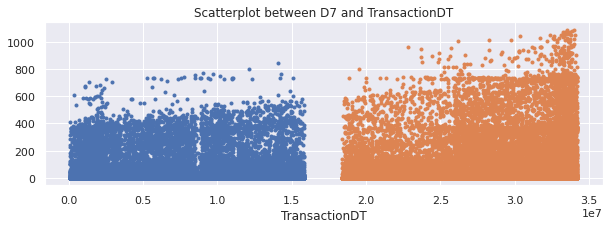

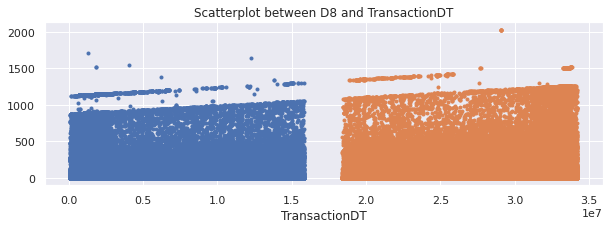

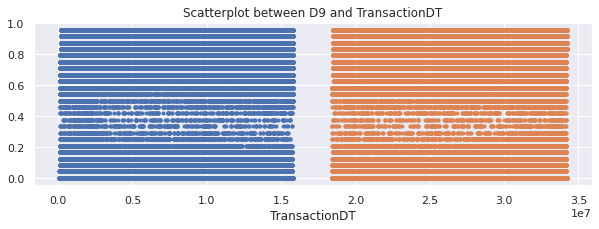

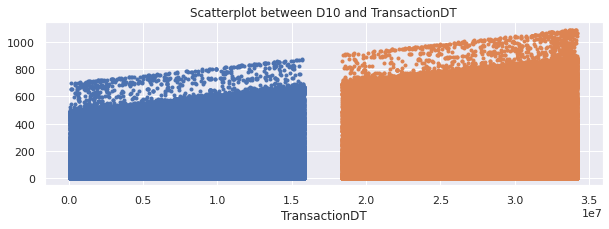

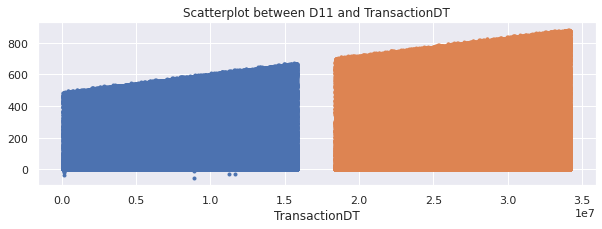

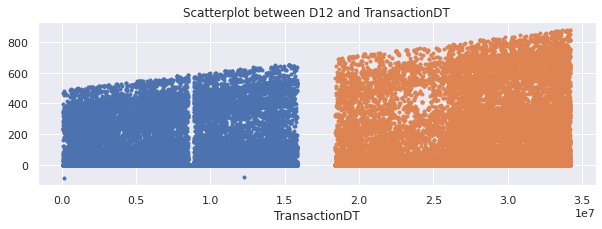

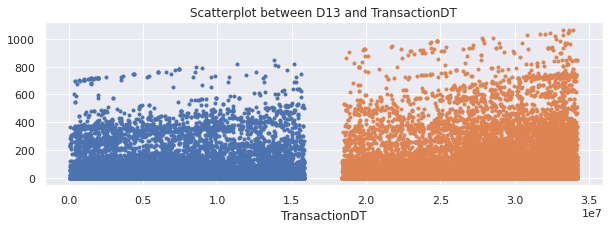

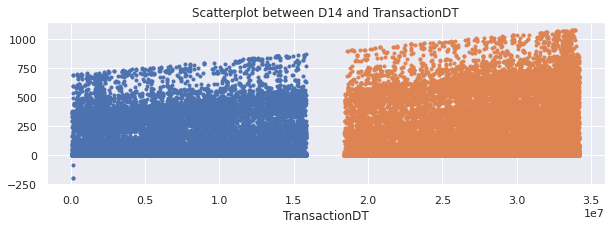

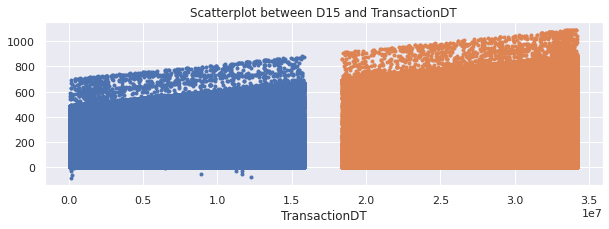

In [ ]:
d_features = list(train_transaction.columns[31:46])
for i in d_features:
    train_transaction.set_index('TransactionDT')[i].fillna(0) \
    .plot(style='.', title=f'Scatterplot between {i} and TransactionDT',
          figsize=(10, 3))
    test_transaction.set_index('TransactionDT')[i].fillna(0) \
    .plot(style='.', figsize=(10, 3))
    plt.show()

- Từ biểu đồ correlation heatmap ta có thể thấy được rõ ràng và chi tiết sự tương quan giữa các thuộc tính với nhau.Đây là thông tin chủ yếu để giúp tôi giảm chiều dữ liệu trong phần sau .
- Từ biểu đồ scatterplot của D1-D15 , ta có thể thấy được liệu có sự tương tự giữa hình dạng cũng như phân bố của D1-D15 với “TransactionDT”.Đây là thông tin quan trọng để đáng giá xem tại sao lại có sự khác nhau đó và điều đó thể hiện điều gì.

#**12. V1-V339**

 V là thuộc tính mà Vesta thiết kế với các thông tin phong phú, bao gồm xếp hạng, đếm và các quan hệ thực thể khác, tính năng số .Tuy vậy rất nhiều tính năng V bị thiếu giá trị (NAN).

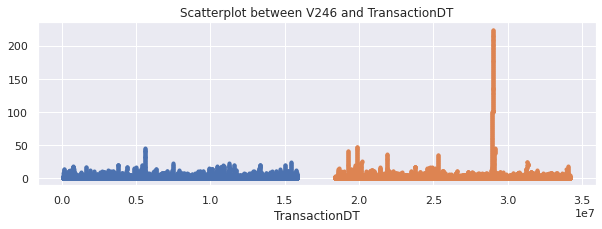

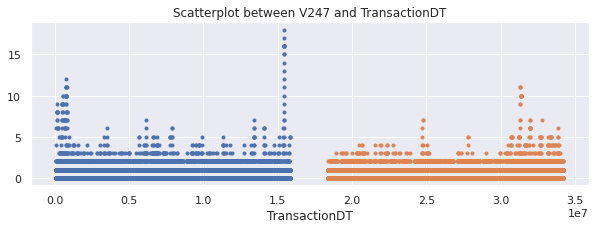

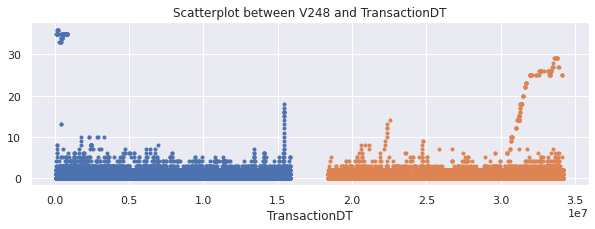

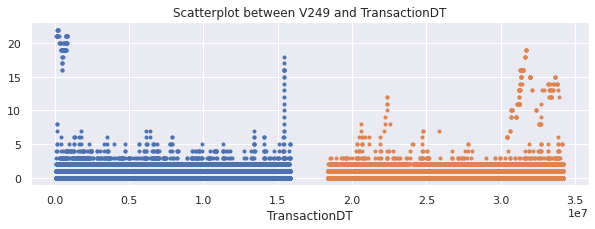

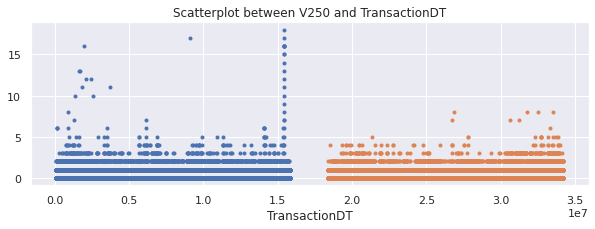

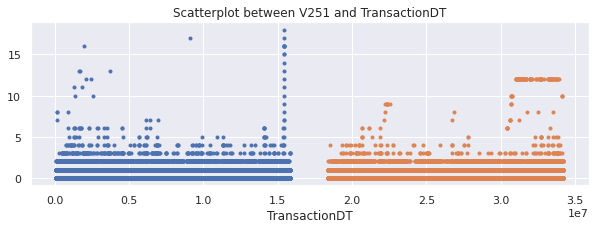

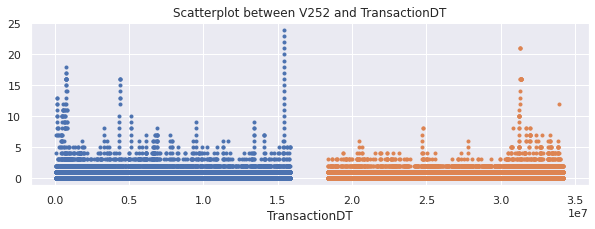

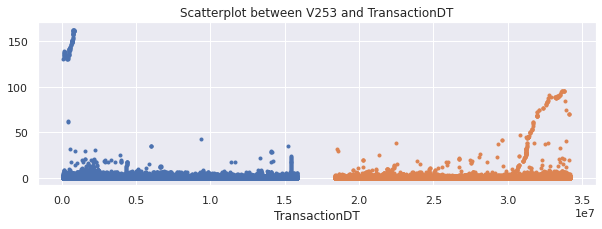

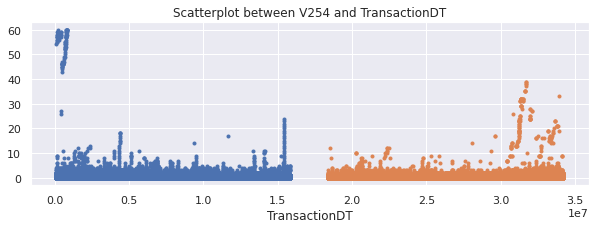

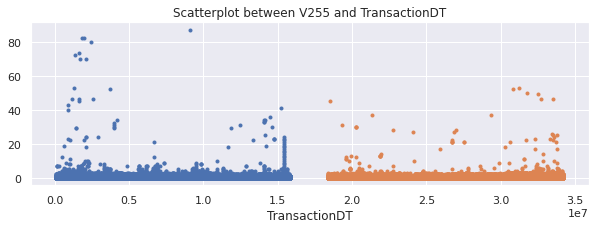

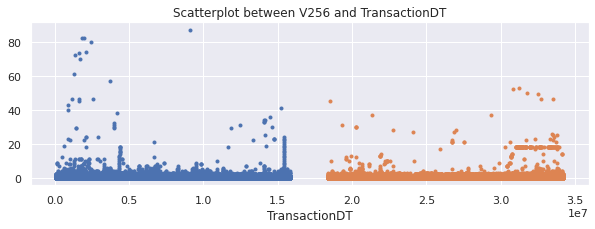

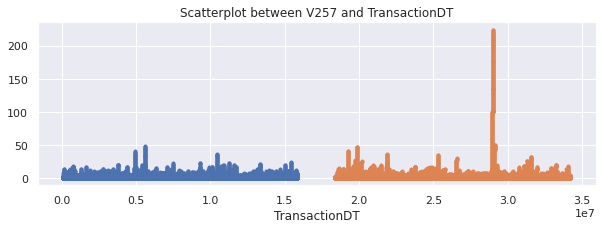

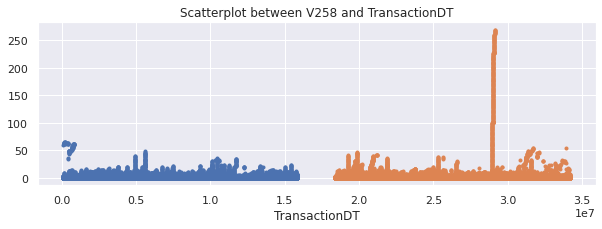

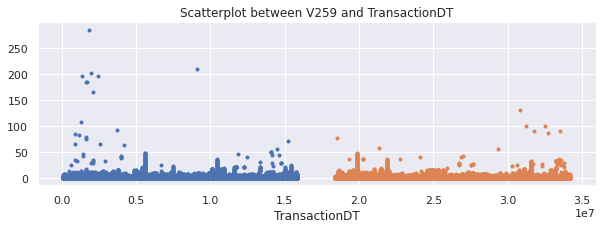

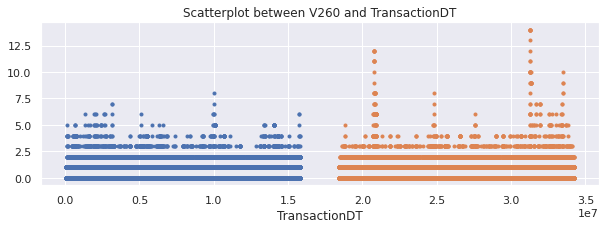

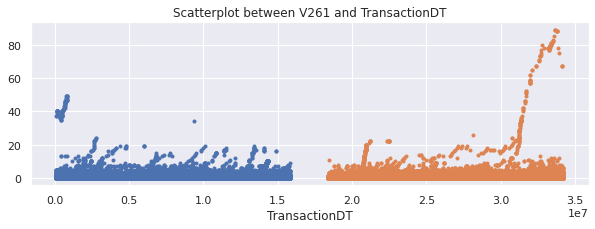

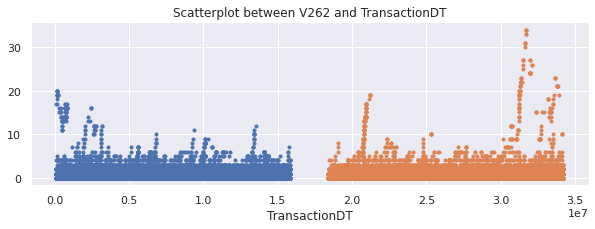

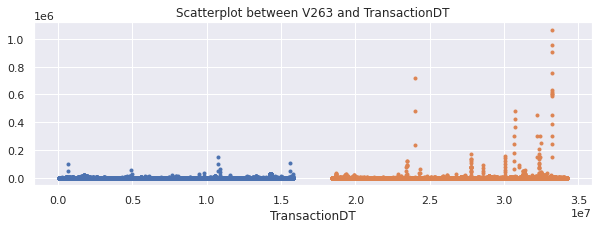

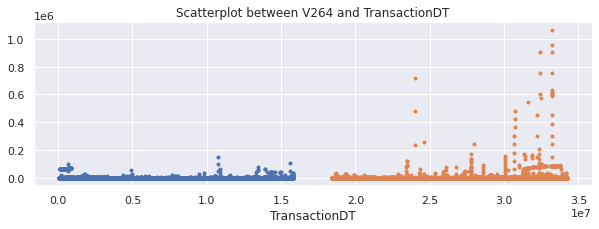

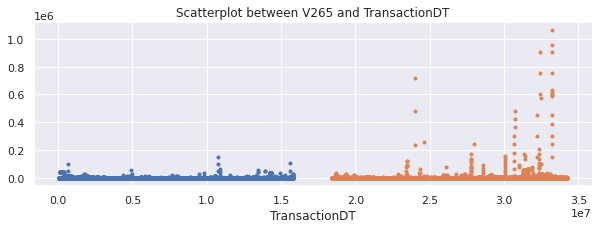

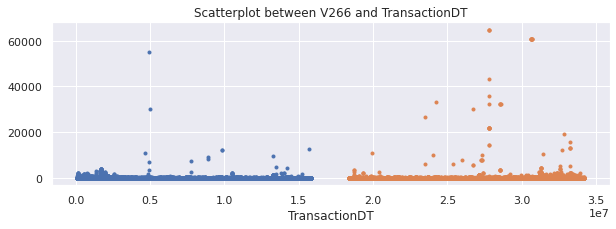

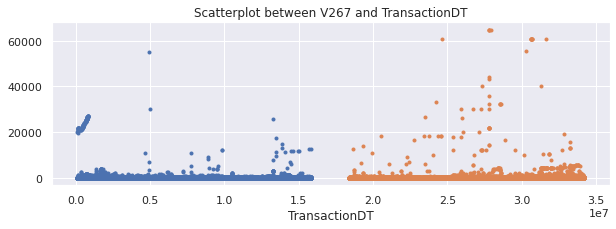

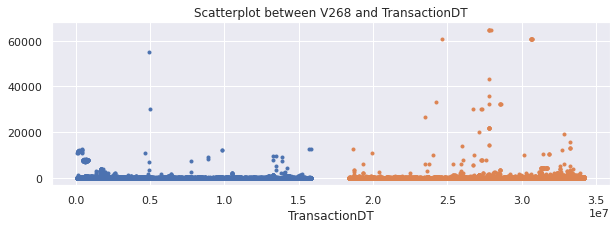

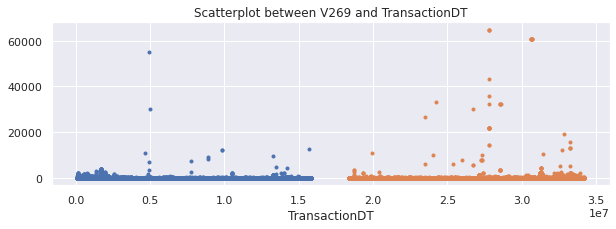

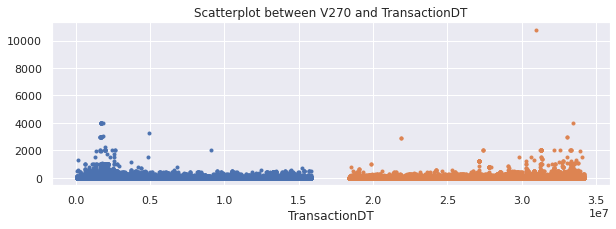

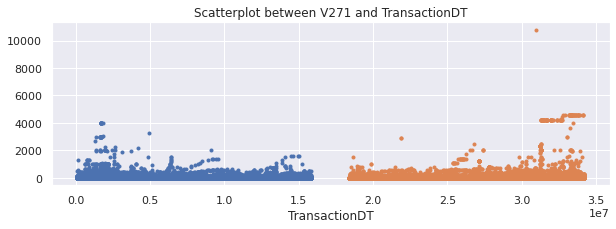

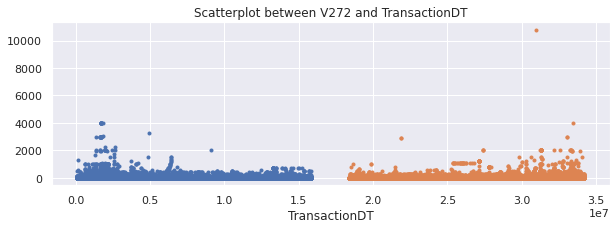

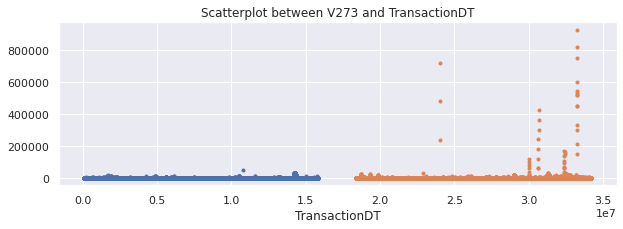

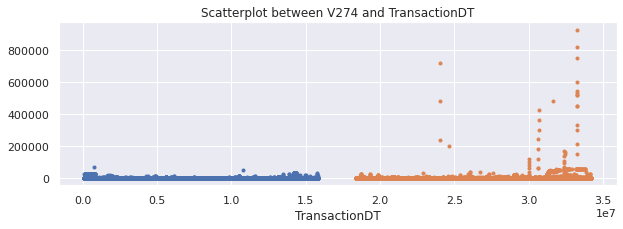

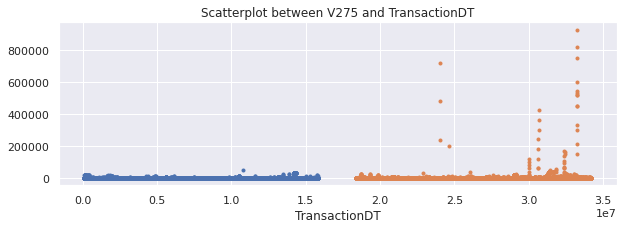

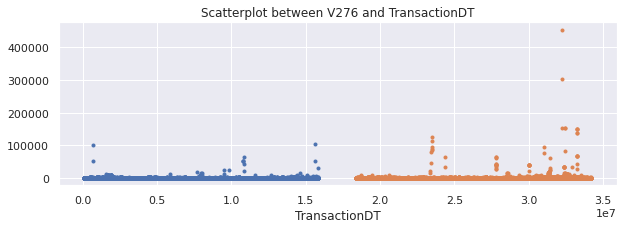

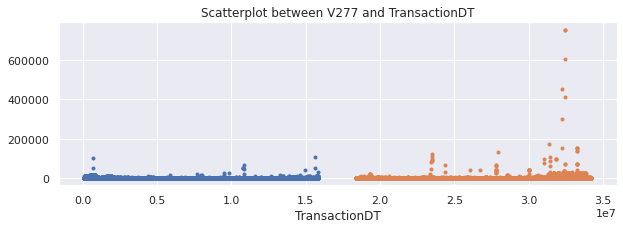

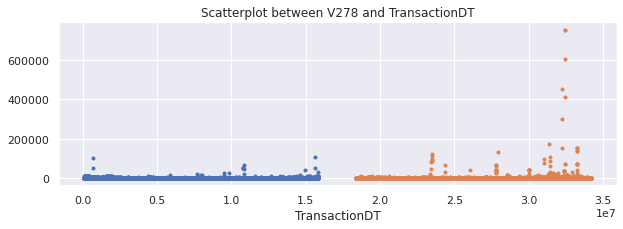

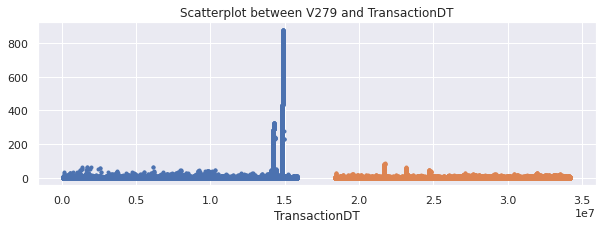

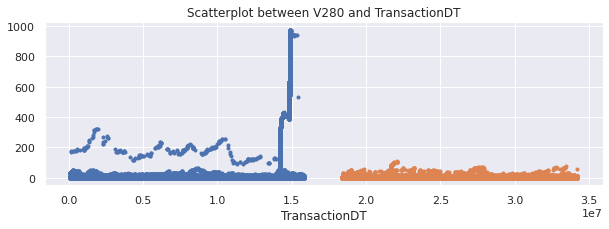

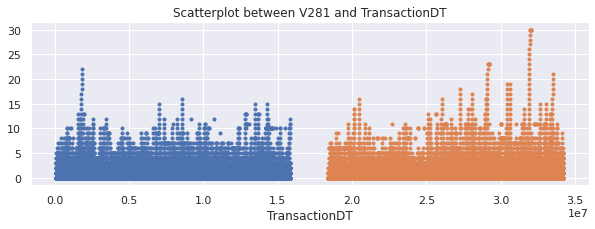

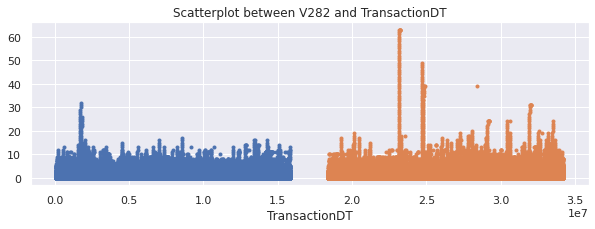

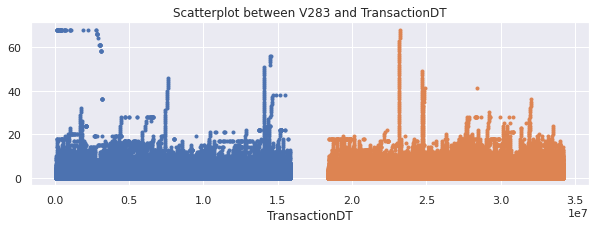

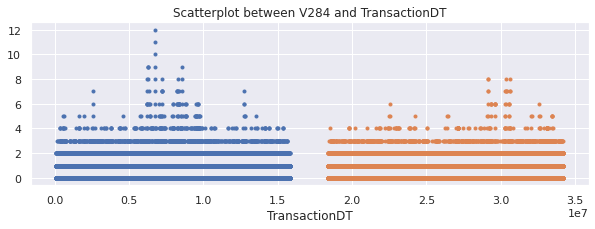

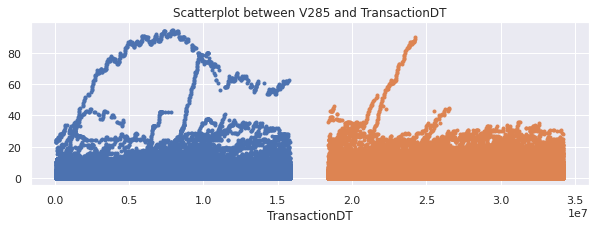

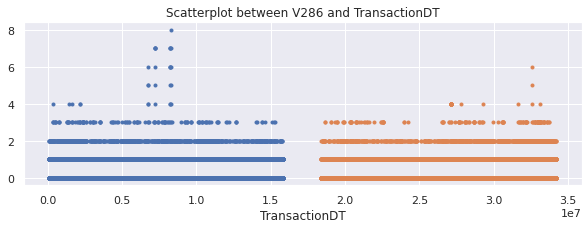

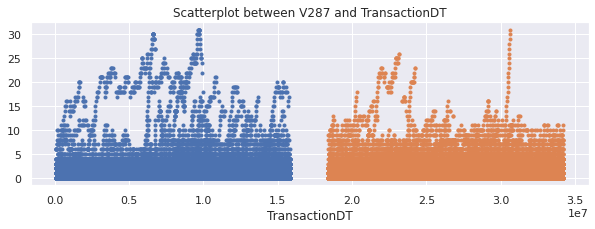

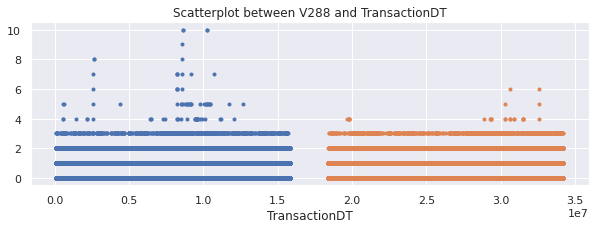

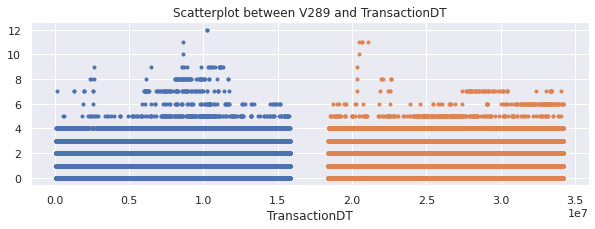

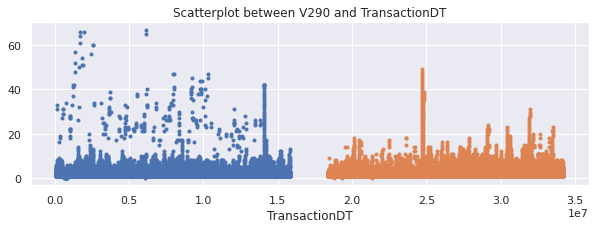

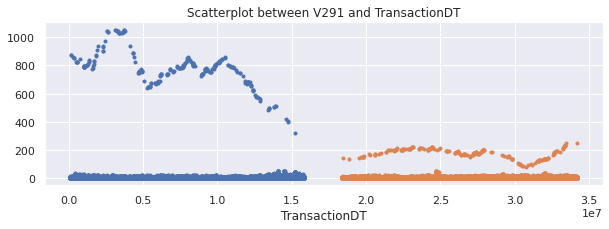

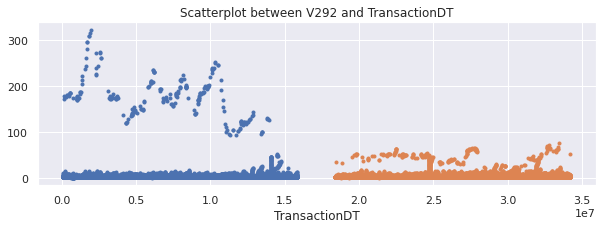

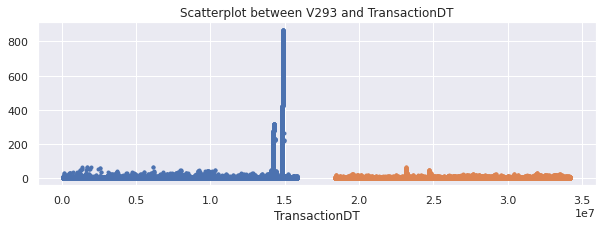

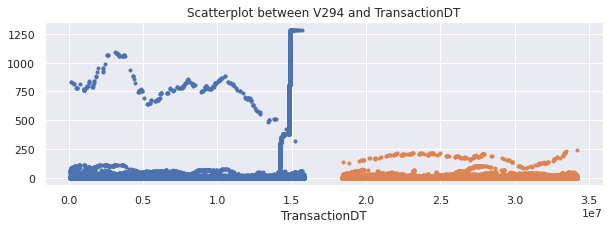

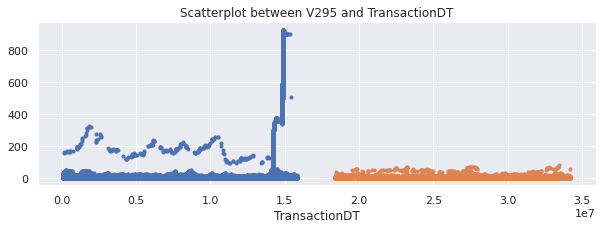

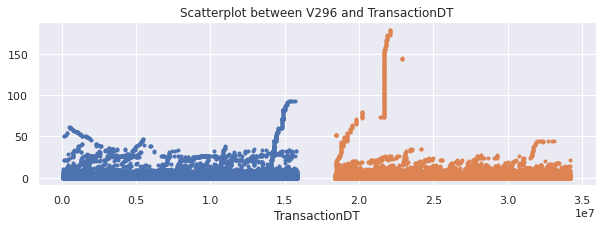

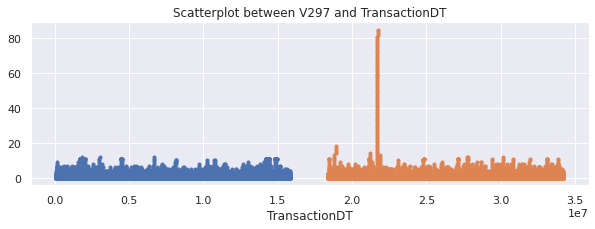

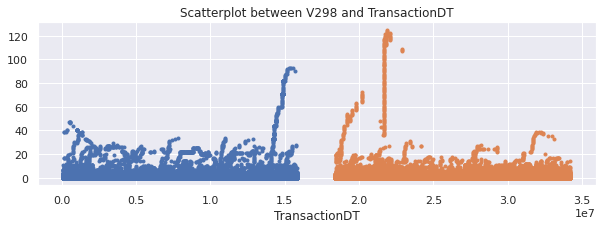

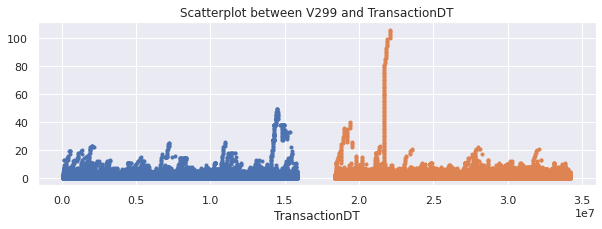

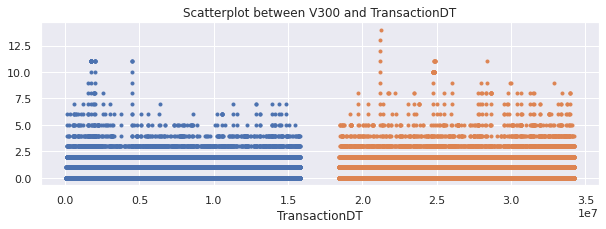

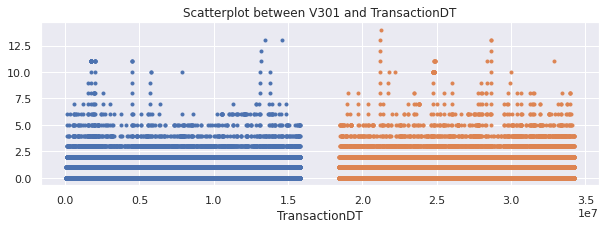

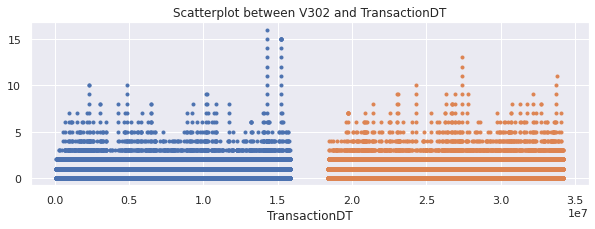

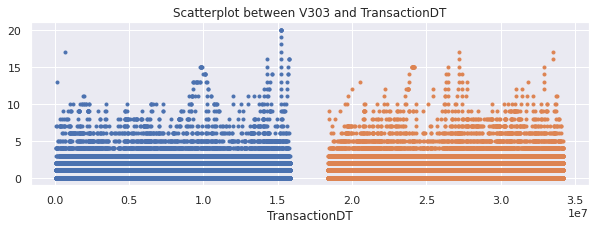

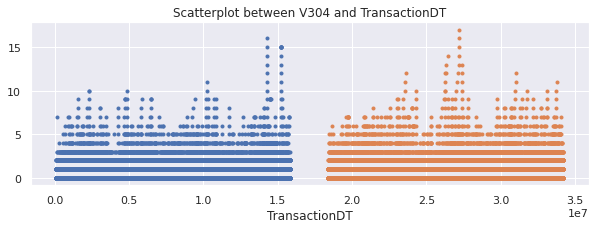

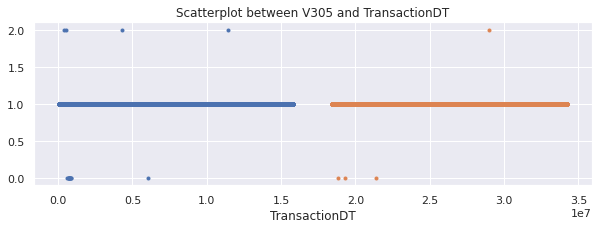

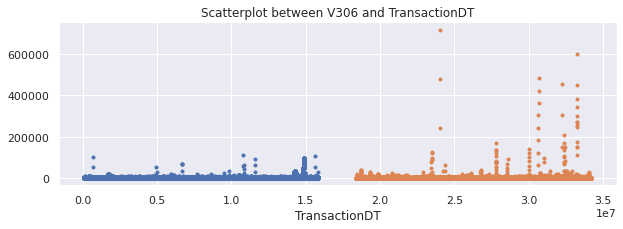

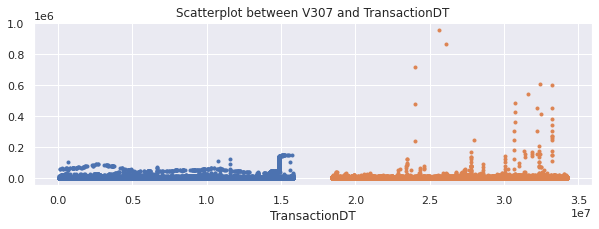

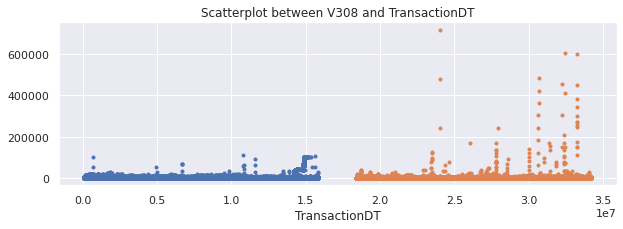

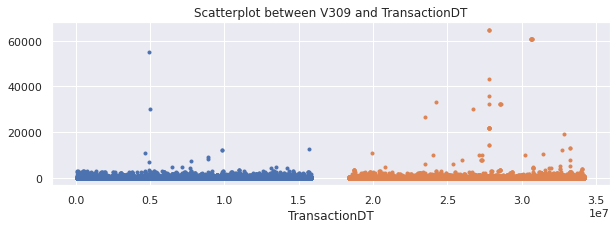

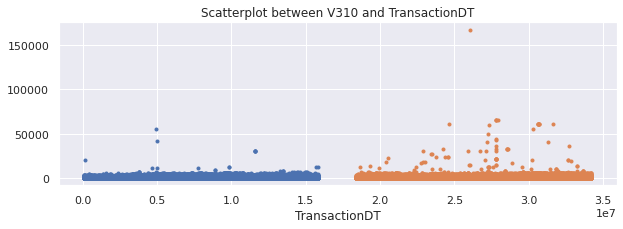

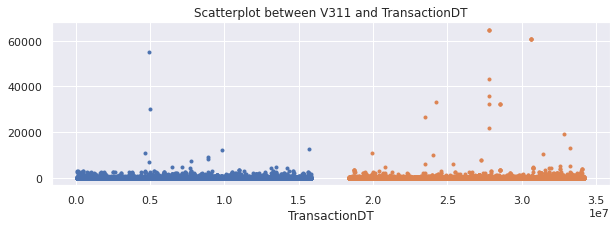

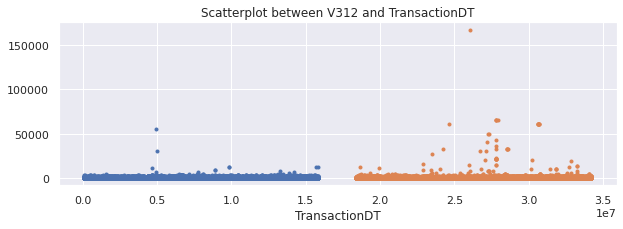

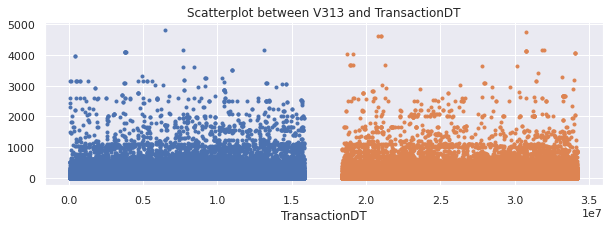

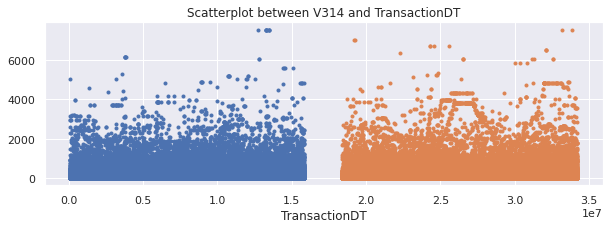

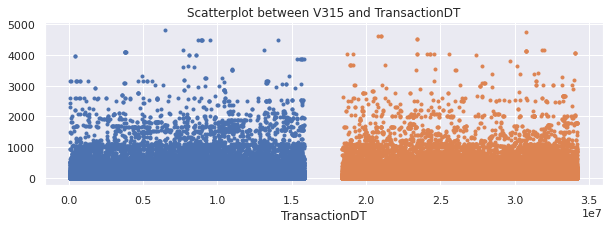

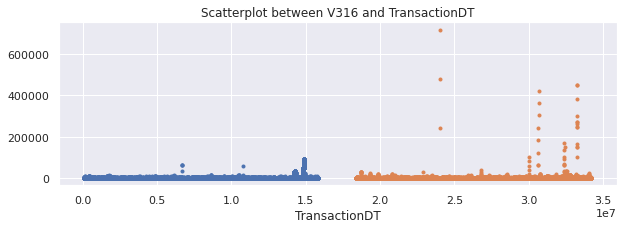

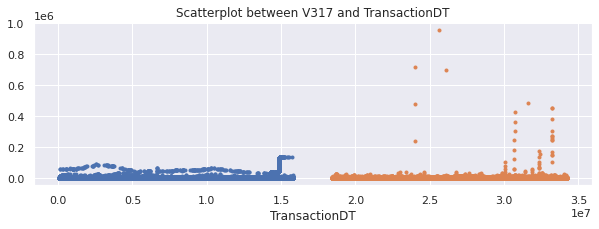

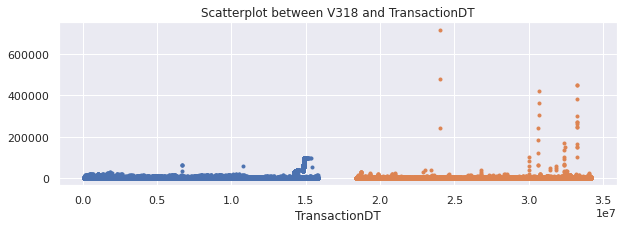

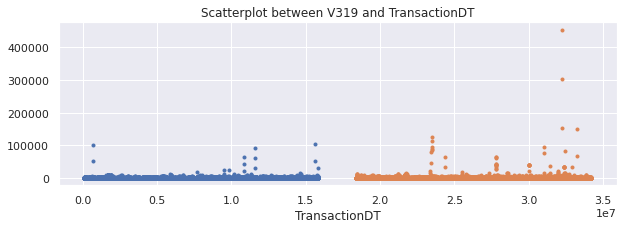

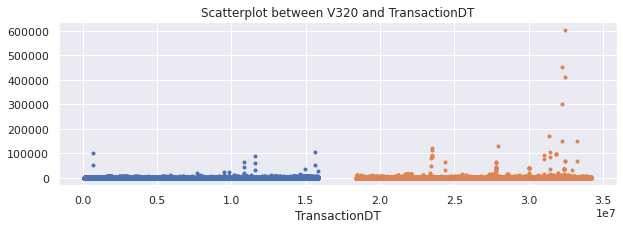

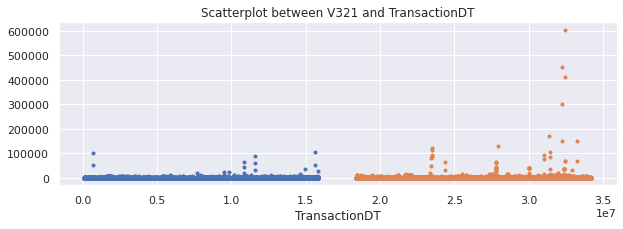

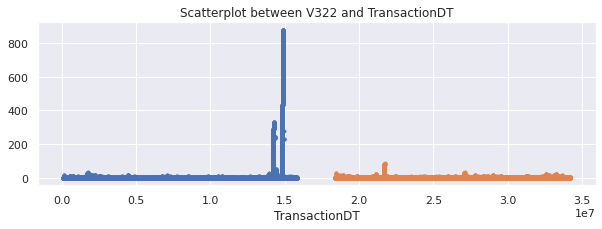

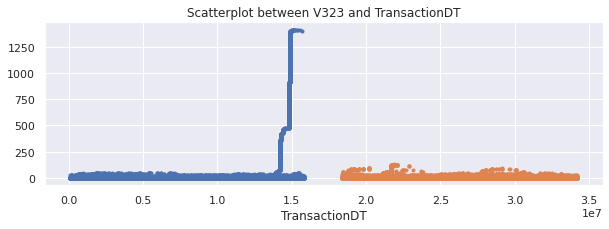

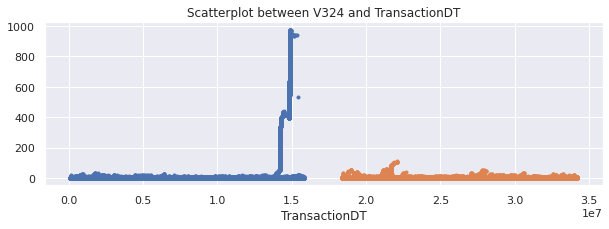

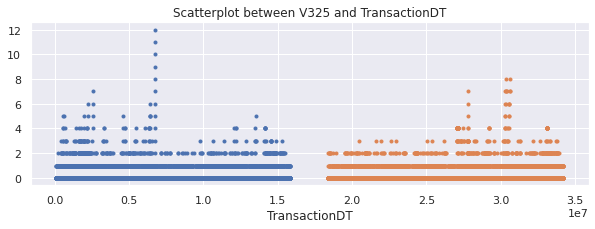

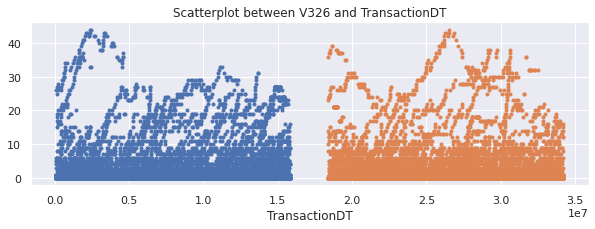

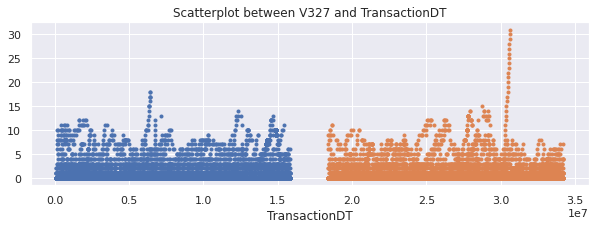

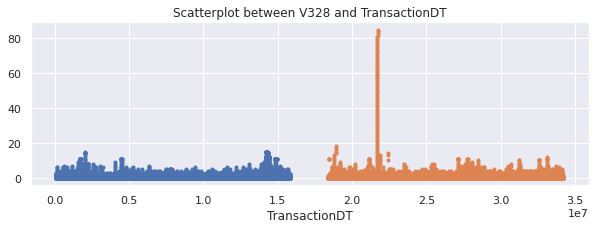

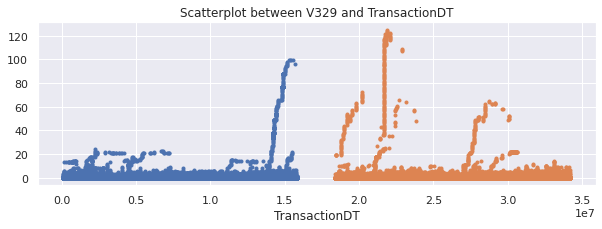

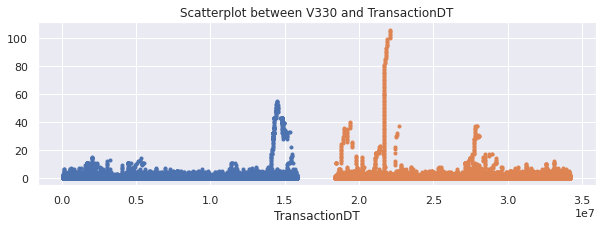

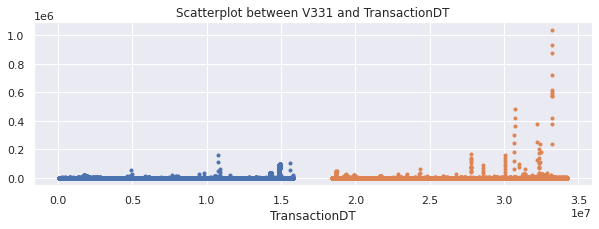

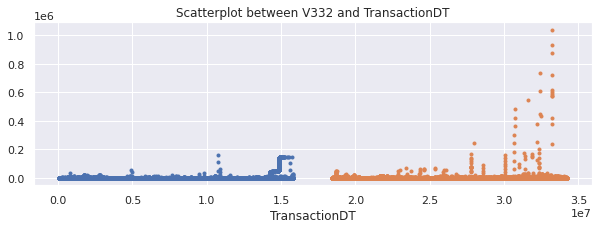

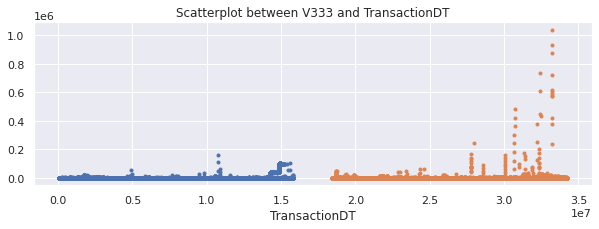

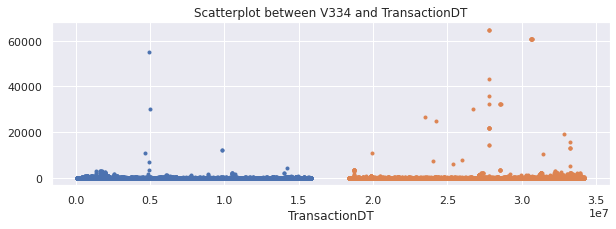

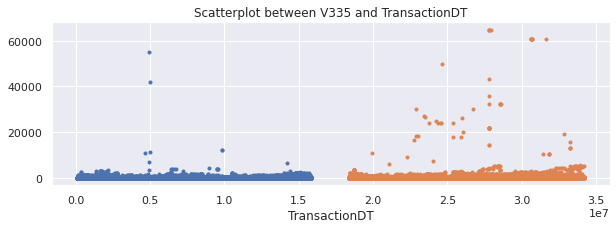

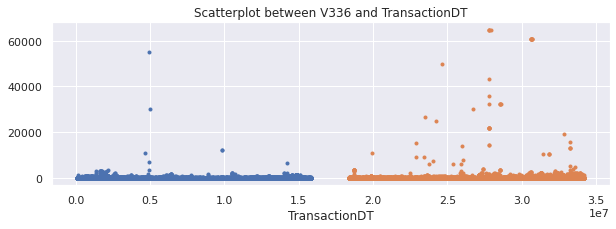

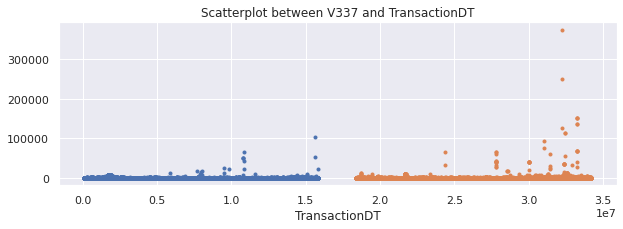

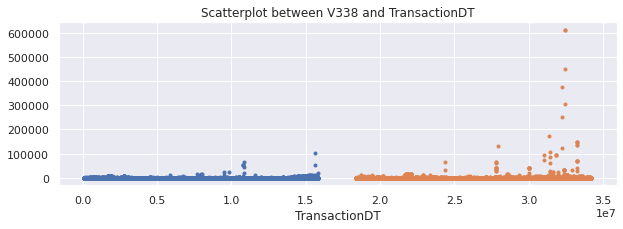

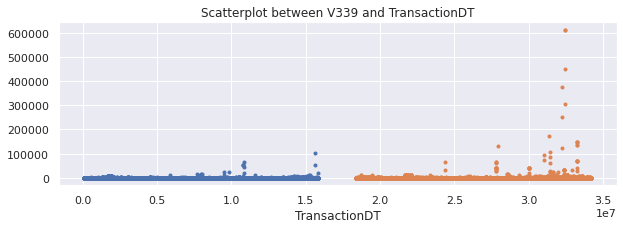

In [ ]:
v_features = list(train_transaction.columns[300:])
for i in v_features:
    train_transaction.set_index('TransactionDT')[i].fillna(0) \
    .plot(style='.', title=f'Scatterplot between {i} and TransactionDT',
          figsize=(10, 3))
    test_transaction.set_index('TransactionDT')[i].fillna(0) \
    .plot(style='.', figsize=(10, 3))
    plt.show()

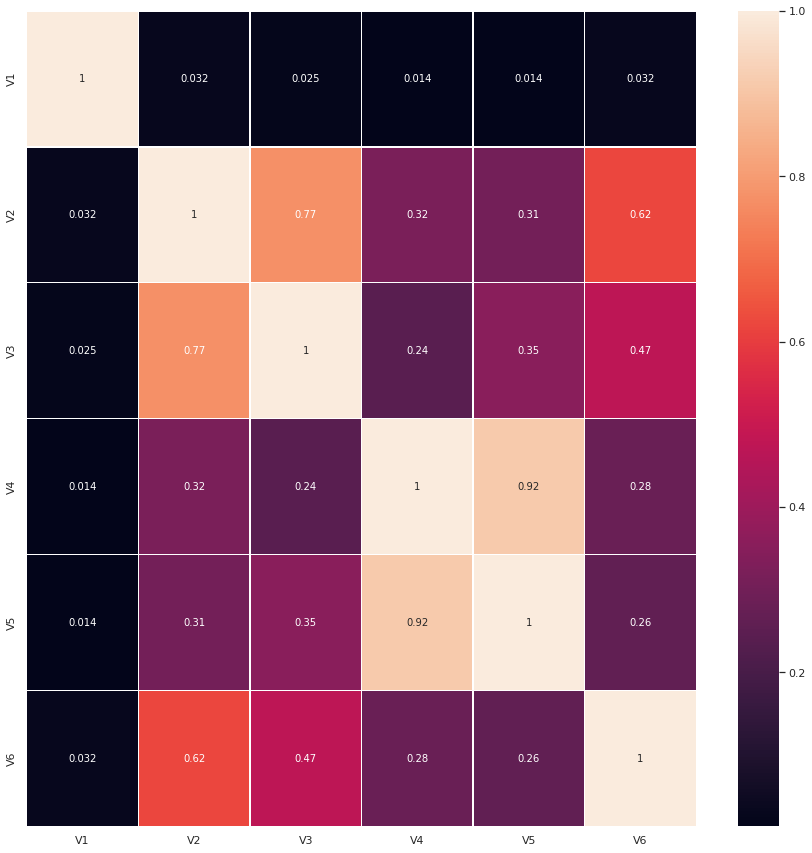

In [ ]:
corr = train_transaction.iloc[:, 47:61].corr()
fig, ax = plt.subplots(figsize=(15, 15))
sns.heatmap(corr, linewidths=.5, annot=True, ax=ax)

- Từ biểu đồ correlation heatmap ta có thể thấy được rõ ràng và chi tiết sự tương quan giữa các thuộc tính với nhau. Tồn tại mối tương quan chặt chẽ (> 0,9) giữa nhiều thuộc tính . Nếu có thể tốt hơn hết ta nên giảm số lượng các tính năng này vì nó có thể làm giảm độ phức tạp tính toán của mô hình..Đây là thông tin chủ yếu để giúp tôi giảm chiều dữ liệu trong phần sau .
- Từ biểu đồ scatterplot của V1-V339 , ta có thể thấy được liệu có sự tương tự giữa hình dạng cũng như phân bố của V1-V339 với “TransactionDT”. Đây là thông tin quan trọng để đáng giá xem tại sao lại có sự khác nhau đó và điều đó thể hiện điều gì.

#**II. Covert, clean ,xử lý dữ liệu**

# **1. Giảm bộ nhớ**

Làm việc với dữ liệu lớn trong khi đào tạo mô hình ML yêu cầu bộ nhớ RAM lớn. Để khắc phục hạn chế này, ta sử dụng một hàm để giảm dung lượng bộ nhớ của dữ liệu. Cách tiếp cận chung là chuyển đổi loại dtype của từng tính năng ('int16', 'int32', 'int64', 'float16', 'float32', 'float64') thành loại dtype thấp nhất có thể.

In [ ]:
'''
# Giảm bộ nhớ
def reduce_mem_usage(df, verbose=True):
    #các loại dtype
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: 
        print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df'''
  

"\n# Giảm bộ nhớ\ndef reduce_mem_usage(df, verbose=True):\n    #các loại dtype\n    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']\n    start_mem = df.memory_usage().sum() / 1024**2    \n    for col in df.columns:\n        col_type = df[col].dtypes\n        if col_type in numerics:\n            c_min = df[col].min()\n            c_max = df[col].max()\n            if str(col_type)[:3] == 'int':\n                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:\n                    df[col] = df[col].astype(np.int8)\n                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:\n                    df[col] = df[col].astype(np.int16)\n                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:\n                    df[col] = df[col].astype(np.int32)\n                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:\n                    df[col] = df[col].astype(np.int64)  \n

In [ ]:
'''train_identity = reduce_mem_usage(train_identity)
train_transaction = reduce_mem_usage(train_transaction)
test_identity = reduce_mem_usage(test_identity)
test_transaction = reduce_mem_usage(test_transaction)'''

'train_identity = reduce_mem_usage(train_identity)\ntrain_transaction = reduce_mem_usage(train_transaction)\ntest_identity = reduce_mem_usage(test_identity)\ntest_transaction = reduce_mem_usage(test_transaction)'

# **2. Sửa các cột bị đánh nhãn lỗi**

In [ ]:
test_identity = test_identity.rename(columns={"id-01": "id_01", "id-02": "id_02", "id-03": "id_03",
                             "id-06": "id_06", "id-05": "id_05", "id-04": "id_04",
                             "id-07": "id_07", "id-08": "id_08", "id-09": "id_09",
                             "id-10": "id_10", "id-11": "id_11", "id-12": "id_12",
                             "id-15": "id_15", "id-14": "id_14", "id-13": "id_13",
                             "id-16": "id_16", "id-17": "id_17", "id-18": "id_18",
                             "id-21": "id_21", "id-20": "id_20", "id-19": "id_19",
                             "id-22": "id_22", "id-23": "id_23", "id-24": "id_24",
                             "id-27": "id_27", "id-26": "id_26", "id-25": "id_25",
                             "id-28": "id_28", "id-29": "id_29", "id-30": "id_30",
                             "id-31": "id_31", "id-32": "id_32", "id-33": "id_33",
                             "id-34": "id_34", "id-35": "id_35", "id-36": "id_36",
                             "id-37": "id_37", "id-38": "id_38"})
test_identity.head() 

,TransactionID,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,3663586,-45.0,280290.0,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,100.0,NotFound,27.0,NaN,New,NotFound,225.0,15.0,427.0,563.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,NaN,chrome 67.0 for android,NaN,NaN,NaN,F,F,T,F,mobile,MYA-L13 Build/HUAWEIMYA-L13
1,3663588,0.0,3579.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,100.0,Found,NaN,-300.0,Found,Found,166.0,NaN,542.0,368.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Found,Found,Android 6.0.1,chrome 67.0 for android,24.0,1280x720,match_status:2,T,F,T,T,mobile,LGLS676 Build/MXB48T
2,3663597,-5.0,185210.0,NaN,NaN,1.0,0.0,NaN,NaN,NaN,NaN,100.0,NotFound,52.0,-360.0,New,NotFound,225.0,NaN,271.0,507.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,NaN,ie 11.0 for tablet,NaN,NaN,NaN,F,T,T,F,desktop,Trident/7.0
3,3663601,-45.0,252944.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,100.0,NotFound,27.0,NaN,Found,Found,225.0,15.0,427.0,563.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Found,Found,NaN,chrome 67.0 for android,NaN,NaN,NaN,F,F,T,F,mobile,MYA-L13 Build/HUAWEIMYA-L13
4,3663602,-95.0,328680.0,NaN,NaN,7.0,-33.0,NaN,NaN,NaN,NaN,100.0,NotFound,27.0,NaN,New,NotFound,225.0,15.0,567.0,507.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,NaN,chrome 67.0 for android,NaN,NaN,NaN,F,F,T,F,mobile,SM-G9650 Build/R16NW


In [ ]:
differentcolumns(train_identity.columns, test_identity.columns) 

Hầu hết các giá trị của 'TransactionID' là unique nên nó sẽ không mang lại thông tin gì.Vậy nên ta sẽ bỏ nó

In [ ]:
train = train.drop('TransactionID', axis=1)
test = test.drop('TransactionID', axis=1)

In [ ]:
gc.collect()

184

# **3. Nối dữ liệu tệp Transaction và Identity Data:**

In [ ]:
train = pd.merge(train_transaction, train_identity, on = 'TransactionID', how = 'left')
test = pd.merge(test_transaction, test_identity, on = 'TransactionID', how = 'left')

In [ ]:
del train_identity, train_transaction, test_identity, test_transaction

# **4. Feature  Engineering**

Trong phần trên ta thấy trong dataset có rất nhiều giá trị NAN . Việc lấy tất cả các cột là không cần thiết.Remove collinear features (xóa các đặc trưng có tính tương đồng cao) trong khung dữ liệu có hệ số tương quan lớn hơn một ngưỡng nhất định . Việc loại bỏ các đặc trưng này có thể giúp mô hình tổng quát hóa và cải thiện khả năng diễn giải của mô hình.

Cách giảm số lượng cột dựa trên số lượng giá trị NaN và coorelation:

- Nhóm các cột dựa trên số lượng giá trị bị thiếu Ví dụ: nếu có 4 columsn v1, v2, v3 và v4. Nếu v1 và v3 có 56 giá trị bị thiếu và v2 có 21 và v4 có 5 giá trị bị thiếu, chúng ta có 3 nhóm ['v1', 'v3'], ['v2'] và ['v4'] cho mỗi nhóm: 2.1] Đối với mỗi cột trong nhóm đó, hãy tìm hệ số coorelation với các cột khác và chỉ lấy các cột có hệ số coorelation> 0,75.
- Lấy danh sách lớn nhất với các đại lượng chung làm nhóm con. Mỗi nhóm chứa một số nhóm con Ví dụ: nếu chúng ta có [[v1, v2], [v6], [v1, v4, v2, v5], [v5, v4] ], đầu ra của chúng tôi sẽ là [[v1, v2, v4, v5], [v6]]
- Bây giờ từ mỗi nhóm con, hãy chọn cột có nhiều giá trị đặc biệt nhất .
- Ví dụ: trong nhóm con [v1, v2, v4, v5], hãy để v2 có hầu hết các giá trị duy nhất để đầu ra của chúng ta trở thành [v2, v6]

In [ ]:
def top_missing_cols(df,n=10,thresh=80):
    """
    returns missing columns in dataframe with missing values percent > thresh
    if n=None. It will gave whole dataframe with missing values percent > thresh
    """
    
    dff = (df.isnull().sum()/df.shape[0])*100
    dff = dff.reset_index()
    dff.columns = ['col','missing_percent']
    dff = dff.sort_values(by=['missing_percent'],ascending=False).reset_index(drop=True)
    print(f'There are {df.isnull().any().sum()} columns in this dataset with missing values.')
    print(f'There are {dff[dff["missing_percent"] > thresh].shape[0]} columns with missing percent values than {thresh}%')
    if n:
        return dff.head(n)
    else:
        return dff

In [ ]:
df_missing = top_missing_cols(train,n=None,thresh=50)
# Taking all column with missing percentage over the value of 50%
missing_cols = df_missing['col']

There are 414 columns in this dataset with missing values.
There are 214 columns with missing percent values than 50%


In [ ]:
# I will take all columns and group them based on missing percentage
nan_dict = {}
for col in missing_cols:
    count = train[col].isnull().sum()
    try:
        nan_dict[count].append(col)
    except:
        nan_dict[count] = [col]
        
for k,v in nan_dict.items():
    print(f'#####' * 4)
    print(f'NAN count = {k} percent: {(int(k)/train.shape[0])*100} %')
    print(v)

####################
NAN count = 585793 percent: 99.19615944728554 %
['id_24']
####################
NAN count = 585408 percent: 99.13096487960172 %
['id_25']
####################
NAN count = 585385 percent: 99.12707013919464 %
['id_07', 'id_08']
####################
NAN count = 585381 percent: 99.12639279303687 %
['id_21']
####################
NAN count = 585377 percent: 99.12571544687913 %
['id_26']
####################
NAN count = 585371 percent: 99.1246994276425 %
['id_27', 'id_23', 'id_22']
####################
NAN count = 552913 percent: 93.62837403054831 %
['dist2']
####################
NAN count = 551623 percent: 93.40992989467267 %
['D7']
####################
NAN count = 545427 percent: 92.36072069631184 %
['id_18']
####################
NAN count = 528588 percent: 89.50926270870728 %
['D13']
####################
NAN count = 528353 percent: 89.46946862193924 %
['D14']
####################
NAN count = 525823 percent: 89.04104717715988 %
['D12']
####################
NAN count = 52

In [ ]:
def coorelation_analysis(cols,title='Coorelation Analysis',size=(12,12)):
    cols = sorted(cols)
    fig,axes = plt.subplots(1,1,figsize=size)
    df_corr = train[cols].corr()
    sns.heatmap(df_corr,annot=True,cmap='RdBu_r')
    axes.title.set_text(title)
    plt.show()

In [ ]:
def reduce_groups(grps):
    '''
    determining columns that have more unique values among a group of atttributes
    '''
    use = []
    for col in grps:
        max_unique = 0
        max_index = 0
        for i,c in enumerate(col):
            n = train[c].nunique()
            if n > max_unique:
                max_unique = n
                max_index = i
        use.append(col[max_index])
    return use

In [ ]:
# column details
cat_cols = (['ProductCD'] + 
            ['card%d' % i for i in range(1, 7)] + 
            ['addr1', 'addr2', 'P_emaildomain', 'R_emaildomain'] + 
            ['M%d' % i for i in range(1, 10)] + 
            ['DeviceType', 'DeviceInfo'] +
            ['id_%d' % i for i in range(12, 39)])


type_map = {c: str for c in cat_cols}
train[cat_cols] = train[cat_cols].astype(type_map, copy=False)
test[cat_cols] = test[cat_cols].astype(type_map, copy=False)

######################################################################################

id_cols = ['TransactionID', 'TransactionDT']
target = 'isFraud'

numeric_cols =  [
    'TransactionAmt', 'dist1', 'dist2', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 
    'C11', 'C12', 'C13', 'C14', 'D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'D8', 'D9', 'D10', 'D11', 
    'D12', 'D13', 'D14', 'D15', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 
    'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 
    'V26', 'V27', 'V28', 'V29', 'V30', 'V31', 'V32', 'V33', 'V34', 'V35', 'V36', 'V37', 'V38', 'V39', 
    'V40', 'V41', 'V42', 'V43', 'V44', 'V45', 'V46', 'V47', 'V48', 'V49', 'V50', 'V51', 'V52', 'V53', 
    'V54', 'V55', 'V56', 'V57', 'V58', 'V59', 'V60', 'V61', 'V62', 'V63', 'V64', 'V65', 'V66', 'V67', 
    'V68', 'V69', 'V70', 'V71', 'V72', 'V73', 'V74', 'V75', 'V76', 'V77', 'V78', 'V79', 'V80', 'V81', 
    'V82', 'V83', 'V84', 'V85', 'V86', 'V87', 'V88', 'V89', 'V90', 'V91', 'V92', 'V93', 'V94', 'V95', 
    'V96', 'V97', 'V98', 'V99', 'V100', 'V101', 'V102', 'V103', 'V104', 'V105', 'V106', 'V107', 'V108', 
    'V109', 'V110', 'V111', 'V112', 'V113', 'V114', 'V115', 'V116', 'V117', 'V118', 'V119', 'V120', 
    'V121', 'V122', 'V123', 'V124', 'V125', 'V126', 'V127', 'V128', 'V129', 'V130', 'V131', 'V132', 
    'V133', 'V134', 'V135', 'V136', 'V137', 'V138', 'V139', 'V140', 'V141', 'V142', 'V143', 'V144', 
    'V145', 'V146', 'V147', 'V148', 'V149', 'V150', 'V151', 'V152', 'V153', 'V154', 'V155', 'V156', 
    'V157', 'V158', 'V159', 'V160', 'V161', 'V162', 'V163', 'V164', 'V165', 'V166', 'V167', 'V168', 
    'V169', 'V170', 'V171', 'V172', 'V173', 'V174', 'V175', 'V176', 'V177', 'V178', 'V179', 'V180', 
    'V181', 'V182', 'V183', 'V184', 'V185', 'V186', 'V187', 'V188', 'V189', 'V190', 'V191', 'V192', 
    'V193', 'V194', 'V195', 'V196', 'V197', 'V198', 'V199', 'V200', 'V201', 'V202', 'V203', 'V204', 
    'V205', 'V206', 'V207', 'V208', 'V209', 'V210', 'V211', 'V212', 'V213', 'V214', 'V215', 'V216', 
    'V217', 'V218', 'V219', 'V220', 'V221', 'V222', 'V223', 'V224', 'V225', 'V226', 'V227', 'V228', 
    'V229', 'V230', 'V231', 'V232', 'V233', 'V234', 'V235', 'V236', 'V237', 'V238', 'V239', 'V240', 
    'V241', 'V242', 'V243', 'V244', 'V245', 'V246', 'V247', 'V248', 'V249', 'V250', 'V251', 'V252', 
    'V253', 'V254', 'V255', 'V256', 'V257', 'V258', 'V259', 'V260', 'V261', 'V262', 'V263', 'V264', 
    'V265', 'V266', 'V267', 'V268', 'V269', 'V270', 'V271', 'V272', 'V273', 'V274', 'V275', 'V276', 
    'V277', 'V278', 'V279', 'V280', 'V281', 'V282', 'V283', 'V284', 'V285', 'V286', 'V287', 'V288', 
    'V289', 'V290', 'V291', 'V292', 'V293', 'V294', 'V295', 'V296', 'V297', 'V298', 'V299', 'V300', 
    'V301', 'V302', 'V303', 'V304', 'V305', 'V306', 'V307', 'V308', 'V309', 'V310', 'V311', 'V312', 
    'V313', 'V314', 'V315', 'V316', 'V317', 'V318', 'V319', 'V320', 'V321', 'V322', 'V323', 'V324', 
    'V325', 'V326', 'V327', 'V328', 'V329', 'V330', 'V331', 'V332', 'V333', 'V334', 'V335', 'V336', 
    'V337', 'V338', 'V339', 'id_01', 'id_02', 'id_03', 'id_04', 'id_05', 'id_06', 'id_07', 'id_08', 
    'id_09', 'id_10', 'id_11'
]


reduced_vcols = ['V1', 'V3', 'V4', 'V6', 'V8', 'V11', 'V13', 'V14', 'V17', 'V20', 
 'V23', 'V26', 'V27', 'V30', 'V36', 'V37', 'V40', 'V41', 'V44', 'V47', 'V48', 'V54', 'V56', 'V59', 
 'V62', 'V65', 'V67', 'V68', 'V70', 'V76', 'V78', 'V80', 'V82', 'V86', 'V88', 'V89', 'V91', 'V96', 
 'V98', 'V99', 'V104', 'V107', 'V108', 'V111', 'V115', 'V117', 'V120', 'V121', 'V123', 'V124', 'V127', 
 'V129', 'V130', 'V136', 'V138', 'V139', 'V142', 'V147', 'V156', 'V162', 'V165', 'V160', 'V166', 'V178',
 'V176', 'V173', 'V182', 'V187', 'V203', 'V205', 'V207', 'V215', 'V169', 'V171', 'V175', 'V180', 'V185', 
 'V188', 'V198', 'V210', 'V209', 'V218', 'V223', 'V224', 'V226', 'V228', 'V229', 'V235', 'V240', 'V258', 
 'V257', 'V253', 'V252', 'V260', 'V261', 'V264', 'V266', 'V267', 'V274', 'V277', 'V220', 'V221', 'V234', 
 'V238', 'V250', 'V271', 'V294', 'V284', 'V285', 'V286', 'V291',
 'V297', 'V303', 'V305', 'V307', 'V309', 'V310', 'V320', 'V281', 'V283', 'V289', 'V296', 'V301', 'V314', 'V332', 'V325', 'V335', 'V338']

In [ ]:
# xóa các dòng có sự tương quan cao  
drop_cols = [col for col in train.columns if col[0] == 'V' and col not in reduced_vcols]

print(f'dropping {len(drop_cols)} columns')
train = train.drop(columns=drop_cols)
test = test.drop(columns=drop_cols)

dropping 211 columns


# **5. Data Splitting for Training**

In [ ]:
#tách dữ liệu chuẩn bị cho việc huấn luyện
y_train = train['isFraud']
X_train = train.drop(columns=['isFraud'])
X_test = test.copy()

print(X_train.shape)
print(X_test.shape)
gc.collect()

(590540, 222)
(506691, 222)


100

# **6. Feature Encoding**

In [ ]:
# Mã hóa nhãn tất cả các cột categorical 
for col in X_train.columns:
    
    if col in cat_cols:
        dff = pd.concat([X_train[col],X_test[col]])
        dff,_ = pd.factorize(dff,sort=True)
        if dff.max()>32000: 
            print(col,'needs int32 datatype')
            
        X_train[col] = dff[:len(X_train)].astype('int16')
        X_test[col] = dff[len(X_train):].astype('int16')

In [ ]:
rem_cols = []
rem_cols.extend(['TransactionDT','TransactionID'])

cols = [col for col in X_train.columns if col not in rem_cols]
len(cols)

220

In [ ]:
# Scale các thuộc tính số
for col in cols:
    if col not in cat_cols:
      
        dff = pd.concat([X_train[col],X_test[col]])
        dff = (dff - dff.min())/(dff.max() - dff.min())
        dff.fillna(-1,inplace=True)

        X_train[col] = dff[:len(X_train)]
        X_test[col] = dff[len(X_train):]

del dff

### Sử dụng gc để giải phóng bộ nhớ

In [ ]:
gc.collect()

76

# **7. PCA for Columns**

Với rất nhiều đặc trưng, hiệu suất của thuật toán của bạn sẽ giảm sút nghiêm trọng. PCA là một cách rất phổ biến để tăng tốc thuật toán Học máy bằng cách loại bỏ các biến tương quan không đóng góp trong bất kỳ quá trình ra quyết định nào. Thời gian đào tạo các thuật toán giảm đáng kể với số lượng tính năng ít hơn. Ngoài ra, Overfitting chủ yếu xảy ra khi có quá nhiều biến trong tập dữ liệu. Vì vậy, PCA giúp khắc phục vấn đề trang bị quá mức bằng cách giảm số lượng tính năng. Vì vậy, nếu kích thước đầu vào quá cao, thì việc sử dụng PCA để tăng tốc thuật toán là một lựa chọn hợp lý. Vì vậy, chúng ta có thể bỏ qua dữ liệu bằng cách áp dụng PCA cho tất cả dữ liệu để giảm số cột / bộ nhớ.

In [ ]:
V_columns = [col for col in train.columns if re.search('^V\d*', col)]
train[V_columns] = train[V_columns].fillna(-1)
test[V_columns] = test[V_columns].fillna(-1)

sc_V = MinMaxScaler()
sc_V.fit(train[V_columns])
train[V_columns] = sc_V.transform(train[V_columns])
test[V_columns] = sc_V.transform(test[V_columns])

In [ ]:
pca = PCA(n_components = 3)
pca.fit(train[V_columns])
pca_V_train = pca.transform(train[V_columns])
pca_V_test = pca.transform(test[V_columns])

np.cumsum(pca.explained_variance_ratio_)

array([0.57790181, 0.77748828, 0.87470773])

In [ ]:
pca_V_train = pd.DataFrame(data = pca_V_train).add_prefix('pca_V')
train = pd.concat([train, pca_V_train], ignore_index=False, sort=False, axis=1)
train.drop(V_columns, axis=1, inplace=True)

pca_V_test = pd.DataFrame(data = pca_V_test).add_prefix('pca_V')
test = pd.concat([test, pca_V_test], ignore_index=False, sort=False, axis=1)
test.drop(V_columns, axis=1, inplace=True)

In [ ]:
del pca_V_train, pca_V_test

In [ ]:
train = train.drop('TransactionDT',axis=1)
test = test.drop('TransactionDT',axis=1)

In [ ]:
train = reduce_mem_usage(train)
test = reduce_mem_usage(test)

gc.collect()

Mem. usage decreased to 281.03 Mb (3.5% reduction)
Mem. usage decreased to 240.64 Mb (3.5% reduction)


0

Nhận xét: Tập dữ liệu được giảm đi đáng kể, khoảng 50% bộ nhớ so với lúc đầu

In [ ]:
#lưu dữ liệu
train.to_pickle('./train_1.pkl') 
test.to_pickle('./test_1.pkl')

In [ ]:
#đọc dữ liệu
train= pd.read_pickle('./train_1.pkl') 
test= pd.read_pickle('./test_1.pkl')

In [ ]:
train.head()

,TransactionID,isFraud,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,...,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo,pca_V0,pca_V1,pca_V2
0,2987000,0,68.5,W,13926,nan,150.0,discover,142.0,credit,315.0,87.0,19.0,NaN,nan,nan,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,NaN,13.0,NaN,NaN,NaN,NaN,NaN,NaN,13.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,-0.120667,0.707520,-0.629883
1,2987001,0,29.0,W,2755,404.0,150.0,mastercard,102.0,credit,325.0,87.0,NaN,NaN,gmail.com,nan,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,-0.001405,-0.698730,-0.063232
2,2987002,0,59.0,W,4663,490.0,150.0,visa,166.0,debit,330.0,87.0,287.0,NaN,outlook.com,nan,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,-0.610352,0.220337,0.182739
3,2987003,0,50.0,W,18132,567.0,150.0,mastercard,117.0,debit,476.0,87.0,NaN,NaN,yahoo.com,nan,2.0,5.0,0.0,0.0,0.0,4.0,0.0,0.0,1.0,0.0,1.0,0.0,25.0,1.0,112.0,112.0,0.0,94.0,0.0,NaN,NaN,NaN,NaN,84.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,-0.066711,-0.695801,-0.053711
4,2987004,0,50.0,H,4497,514.0,150.0,mastercard,102.0,credit,420.0,87.0,NaN,NaN,gmail.com,nan,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.0,NotFound,nan,-480.0,New,NotFound,166.0,nan,542.0,144.0,nan,nan,nan,nan,nan,nan,nan,New,NotFound,Android 7.0,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M,1.910156,0.341553,0.318359


# **III. : Model  sử dụng, hình ảnh , số liệu**

#**1.XGBoost**


In [ ]:
x_train = X_train[cols]
x_test = X_test[cols]


idx_train = x_train.index[:int(x_train.shape[0]*0.75)]  
idx_validation = x_train.index[int(x_train.shape[0]*0.75):]
    
print(f'fitting model on {len(cols)} columns')
clf = xgb.XGBClassifier( 
        n_estimators=2000,
        max_depth=12, 
        learning_rate=0.02, 
        subsample=0.8,
        colsample_bytree=0.4, 
        missing=-1, 
        eval_metric='auc',
        tree_method='gpu_hist' 
          )
model = clf.fit(x_train.loc[idx_train,cols], y_train[idx_train], 
            eval_set=[(x_train.loc[idx_validation,cols],y_train[idx_validation])],
            verbose=50, early_stopping_rounds=100)

fitting model on 220 columns
[0]	validation_0-auc:0.814096
Will train until validation_0-auc hasn't improved in 100 rounds.
[50]	validation_0-auc:0.869283
[100]	validation_0-auc:0.880529
[150]	validation_0-auc:0.891605
[200]	validation_0-auc:0.900448
[250]	validation_0-auc:0.90789
[300]	validation_0-auc:0.91334
[350]	validation_0-auc:0.917458
[400]	validation_0-auc:0.919714
[450]	validation_0-auc:0.920954
[500]	validation_0-auc:0.92186
[550]	validation_0-auc:0.922231
[600]	validation_0-auc:0.922786
[650]	validation_0-auc:0.922783
[700]	validation_0-auc:0.922513
Stopping. Best iteration:
[629]	validation_0-auc:0.922908



In [ ]:
y_train_pred = model.predict(x_train.iloc[idx_train])
y_test_pred = model.predict(x_train.iloc[idx_validation])

train_fpr, train_tpr, thresholds = roc_curve(y_train.iloc[idx_train], model.predict_proba(x_train.iloc[idx_train])[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_train.iloc[idx_validation], model.predict_proba(x_train.iloc[idx_validation])[:,1])

print('Area under train roc {}'.format(auc(train_fpr, train_tpr)))
print('Area under test roc {}'.format(auc(test_fpr, test_tpr)))

Area under train roc 0.9939054861896375
Area under test roc 0.922908021903117


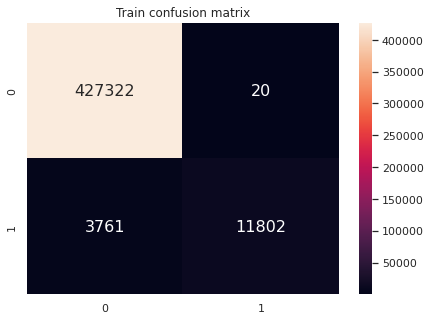

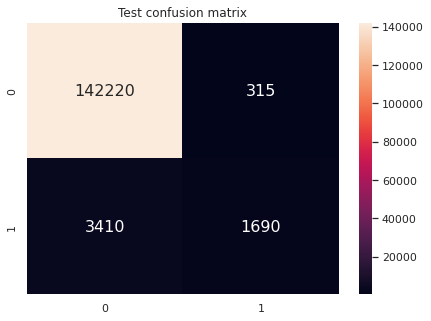

In [ ]:
train_cf = confusion_matrix(y_train.iloc[idx_train],y_train_pred)
plt.figure(figsize=(7,5))
sns.heatmap(train_cf,annot=True,annot_kws={"size": 16},fmt="0")
plt.title('Train confusion matrix')
plt.show()


cv_cf = confusion_matrix(y_train.iloc[idx_validation],y_test_pred)
plt.figure(figsize=(7,5))
sns.heatmap(cv_cf,annot=True,annot_kws={"size": 16},fmt="0")
plt.title('Test confusion matrix')
plt.show()

# **IV.Tạo file nạp bài**


In [ ]:
y_pred_test = model.predict_proba(x_test)[:,1]
submission = pd.read_csv('/content/drive/MyDrive/data/sample_submission.csv')
submission['isFraud'] = y_pred_test
submission.to_csv('/content/drive/MyDrive/data/submission_xgboost_gpu.csv',index=False)